In [1]:
from IPython.display import display
import misc
import matplotlib as mpl
import os
import re
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
import copy
import scipy

from matplotlib import rcParams
from scipy.stats import pearsonr, fisher_exact
from collections import defaultdict
import matplotlib.pyplot as plt
import yaml
import sys
from sklearn.metrics import roc_auc_score

from misc import rename_cytokines, rename_CMs, rename_factors, rename_Y, make_annot, convert_partial_year, rename_blood, rename_pathways, get_phenotype_contrasts
from misc import coef_col, pval_col, padj_col
from bcg_utils import fisher_enrichment
import bcg_utils as utils

%load_ext autoreload
%autoreload 1
%aimport misc
%aimport bcg_utils
%aimport bcg_colors

from bcg_colors import *

In [2]:
_ = utils.setup_plotting(style='ticks', context='notebook', font_scale=1, rc=RC_PAPER)

FIG_SIZE = (1.25, 1.25)
HEATMAP_SIZE = (0.3, 0.3)
CIRCLE_SIZE = 20
CIRCLE_LINE_WIDTH = 0.4
ALPHA = 0.8
LGD_MARKER_SCALE = 1.2

FDR = [0.05]
ATAC_FDR = [0.1]
VOLCANO_MAX_ANNOT = 20
CELL_SIZE = 0.13
LM_VMAX = 5
LM_VMIN = -1 * LM_VMAX
ENR_VMAX = 7
ENR_VMIN = -1 * ENR_VMAX
LOLA_VMAX = 150
LOLA_VMIN = -1 * LOLA_VMAX
TRANSPOSE_ENR_TABLE = True
ENR_FIG_WIDTH, ENR_CELL_HEIGHT = (3, 0.15) if TRANSPOSE_ENR_TABLE else (10, 0.1)
PVAL_ASTERISKS = [0.05, 0.01, 0.001]
CORR_CBAR_KWS = dict(shrink=2, aspect=0.15, orientation='horizontal')

# bootstrapping setup
N_BOOTS = None # 1000
BOOTS_DIR = 'results_bootstrap'
BOOTS_PHENOTYPE = 'innate_nonspecific_24h_wo_LAC_IL10_IL1ra'  # 'adaptive_MTB_7d'
BOOTS_REGIONS = misc.GENE_AND_DISTAL_10kb
BOOT_PCT_THRS = [0, 0.01, 0.05, 0.10, 0.25, 0.5, 0.75]
ERROR_FLIER_SIZE = 2

# scRNAseq
RNA_FDR = 0.1
RNA_EPI_P = 0.05
RNA_RESULTS_DIR = os.path.join('results', 'scRNAseq', 'with_log_counts')
ENR_COLS = [rename_ENR_suppl_cols()[col] for col in get_ENR_suppl_cols() if col != 'Term']

SAVE_FIG = True
fig_dir = utils.make_dir('results', 'figures', 'Figure7')
CELLTYPE = 'PBMC'
TOP_N = 1000
RANK_METRIC = 'p.value'
FORCE_MT_COMPARISON = 8

MODEL_TEMPLATE = 'donor_as_mixed.batch.sex.age.blood.TSS_enr.visit_time.thm.{}_V3_FC1.2_responder'

SWAP_TO_NON_RESP = True

# Suppl. Tables

In [3]:
SAVE_TABLES = False
SUPPL_LIMIT = 5000
suppl_enr = defaultdict(lambda: [])
if SAVE_TABLES:
    suppl_tables = misc.get_container_with_tables(
        [ATAC_V2_V3, ENRICH_V2_V3, ATAC_V2_V3_FULL, ENRICH_V2_V3_PROMOTERS, ENRICH_V2_V3_LOLA],
        modes=['a', 'a', 'a', 'a', 'a']
    )

### Responders and non-responders

/home/lfolkman/miniconda3/envs/BCG/lib/python3.6/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


innate_nonspecific_24h_wo_LAC_IL10_IL1ra Resp: 213 Non-R: 78 Fraction Resp: 0.7319587628865979
NR: 78 R (1.2): 213 R (1.6): 76 R (1.7): 48 R (1.8): 33


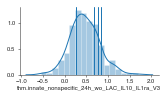

(291, 15) Index(['GM-CSF (Ca)', 'IL-1β (Ca)', 'IL-2RA (Ca)', 'IL-6 (Ca)', 'CXCL10 (Ca)',
       'CXCL9 (Ca)', 'CCL3 (Ca)', 'CCL4 (Ca)', 'TNF-α (Ca)', 'IL-1β (LPS)',
       'IL-6 (LPS)', 'TNF-α (LPS)', 'IL-1β (Sa)', 'IL-6 (Sa)', 'TNF-α (Sa)'],
      dtype='object')


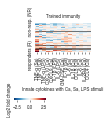

adaptive_MTB_7d Resp: 217 Non-R: 74 Fraction Resp: 0.7457044673539519
NR: 74 R (1.2): 217 R (1.6): 170 R (1.7): 164 R (1.8): 152


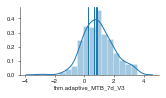

(291, 2) Index(['IFN-γ (Mt)', 'IL-17 (Mt)'], dtype='object')


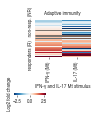

In [5]:
DROP_IF_MISSING_V1_ATAC = False

df = misc.get_sample_annot()
donor_scores_df, lfc_df = misc.make_donor_scores(
    df.loc[:, df.columns.str.contains('^CYTO:.*_good$|^CYTO:C.albicans.yeast_24h_PBMC_IFNg_excluded$')],
    visit='V3', X_df=df[misc.CYTO_MODEL_COLS],
    design='SAMPLE_VISIT + SAMPLE_DONOR + SAMPLE_VISIT_TIME_REAL + ' + misc.replace_chars_for_LM(' + '.join(misc.BLOOD)),
    do_not_correct=['SAMPLE_VISIT'], standard_scaling=False, methods=['top_half_mean'], max_impute_iter=10,
    random_state=misc.RANDOM_STATE, verbose=False)

scored_donors = {}
previous_donors = None
for phenotype, title, xlabel, denominator, xticklabels, hide_ticks in [
    ('innate_nonspecific_24h_wo_LAC_IL10_IL1ra', 'Trained immunity', 'Innate cytokines with Ca, Sa, LPS stimuli', 15, False, True),
    ('adaptive_MTB_7d', 'Adaptive immunity', 'IFN-γ and IL-17 Mt stimulus', 10, True, False)
]:
    _frozen_scores = df.loc[(df['SAMPLE:VISIT'] == 'V3') & (df['SAMPLE:TISSUE'] == 'PBMC')].set_index('SAMPLE:DONOR')['thm.{}_V3'.format(phenotype)]
    _online_scores = donor_scores_df['top_half_mean.{}_V3'.format(phenotype)]
    assert ((_frozen_scores - _online_scores).isnull() | ((_frozen_scores - _online_scores).abs() < 2e-3)).all()

    score = 'thm.{}_V3'.format(phenotype)
    resp_status = 'thm.{}_V3_FC1.2_responder'.format(phenotype)
    assert df[score].isnull().equals(df[resp_status].isnull())
    scored_donors[phenotype] = df.loc[(df['SAMPLE:TISSUE'] == 'PBMC') & ~df[score].isnull()]
    if DROP_IF_MISSING_V1_ATAC:
         scored_donors[phenotype] = scored_donors[phenotype].loc[(scored_donors[phenotype]['SAMPLE:VISIT'] == 'V1') & scored_donors[phenotype]['QC:PASS']]
    scored_donors[phenotype] = scored_donors[phenotype].set_index('SAMPLE:DONOR')
    scored_donors[phenotype] = scored_donors[phenotype].loc[~scored_donors[phenotype].index.duplicated(), [score, resp_status]]
    assert not scored_donors[phenotype].isnull().any().any()
    
    r = (scored_donors[phenotype][resp_status] == 'R').sum()
    nr = (scored_donors[phenotype][resp_status] == 'N').sum()
    print(phenotype, 'Resp:', r, 'Non-R:', nr, 'Fraction Resp:', r / (r + nr))

    assert (scored_donors[phenotype][score] < np.log2(1.2)).sum() == nr
    assert (scored_donors[phenotype][score] >= np.log2(1.2)).sum() == r
    
    _, ax = plt.subplots(figsize=(FIG_SIZE[0] * 2, FIG_SIZE[1]))
    ax = sns.distplot(scored_donors[phenotype][score])
    ax.axvline(np.log2(1.2))
    ax.axvline(np.log2(1.6))
    ax.axvline(np.log2(1.7))
    ax.axvline(np.log2(1.8))
    print('NR:', (scored_donors[phenotype][score] < np.log2(1.2)).sum(),
    'R (1.2):', (scored_donors[phenotype][score] >= np.log2(1.2)).sum(),
    'R (1.6):', (scored_donors[phenotype][score] >= np.log2(1.6)).sum(),
    'R (1.7):', (scored_donors[phenotype][score] >= np.log2(1.7)).sum(),
    'R (1.8):', (scored_donors[phenotype][score] >= np.log2(1.8)).sum())
    sns.despine()
    plt.show()
    
    if previous_donors is None:
        previous_donors = scored_donors[phenotype].index
    else:
        assert previous_donors.equals(scored_donors[phenotype].index)
        
    lfc_df = lfc_df.loc[scored_donors[phenotype].index]
    donor_scores_df = donor_scores_df.loc[scored_donors[phenotype].index]
    
    cytogroups_masks = misc.get_fold_change_cytogroups_masks(lfc_df.columns)
    _lfc_df = lfc_df.iloc[np.argsort(donor_scores_df['top_half_mean.{}_V3'.format(phenotype)]), cytogroups_masks[phenotype]]
    _lfc_df.columns = rename_cytokines(_lfc_df.columns)
    print(_lfc_df.shape, _lfc_df.columns)
    cg = sns.clustermap(_lfc_df, cmap=utils.PALETTE_CODES['diverging'], cbar=True, xticklabels=True, yticklabels=False,
                        row_cluster=False, col_cluster=True, figsize=(FIG_SIZE[0], FIG_SIZE[1]), 
                        cbar_kws=dict(orientation='horizontal'), center=0, vmin=-3, vmax=3)
    for heatmap_child in cg.ax_heatmap.get_children():
        if isinstance(heatmap_child, mpl.collections.QuadMesh):
            heatmap_child.set_rasterized(False)
    cg.ax_col_dendrogram.set_visible(False)
    cg.ax_heatmap.axhline((donor_scores_df['top_half_mean.{}_V3'.format(phenotype)] < np.log2(1.2)).sum(), c='black', lw=0.5)
    cg.ax_heatmap.axhline((donor_scores_df['top_half_mean.{}_V3'.format(phenotype)] < np.log2(1.6)).sum(), c='black', lw=0.5)
    cg.ax_heatmap.axhline((donor_scores_df['top_half_mean.{}_V3'.format(phenotype)] < np.log2(1.7)).sum(), c='black', lw=0.5)
    cg.ax_heatmap.axhline((donor_scores_df['top_half_mean.{}_V3'.format(phenotype)] < np.log2(1.8)).sum(), c='black', lw=0.5)
    cg.cax.tick_params(labelsize=SMALL_FONT)
    cg.cax.set_ylabel('Log2 fold change', fontsize=SMALL_FONT)
    cg.ax_heatmap.set_title(title, fontsize=SMALL_FONT)
    cg.ax_heatmap.tick_params(labelsize=SMALL_FONT)
    cg.ax_heatmap.set_xlabel(xlabel, fontsize=SMALL_FONT)
    cg.ax_heatmap.yaxis.set_label_position('left')
    cg.ax_heatmap.yaxis.tick_left()
    cg.ax_heatmap.set_ylabel('responders (R)   non-resp. (NR)', fontsize=SMALL_FONT)
    cg.cax.set_position([0, 0, 0.3555354, 0.021533])
    if SAVE_FIG:
        utils.savefig(os.path.join(fig_dir, 'BCG.donor_scores.{}{}.svg'.format(phenotype, '.with_xticks' if xticklabels else '')), dpi=DPI)
    plt.show()  

In [6]:
scored_donors['innate_nonspecific_24h_wo_LAC_IL10_IL1ra'] = scored_donors['innate_nonspecific_24h_wo_LAC_IL10_IL1ra'].loc[scored_donors['adaptive_MTB_7d'].index]
print(scipy.stats.spearmanr(scored_donors['innate_nonspecific_24h_wo_LAC_IL10_IL1ra'].iloc[:, 0], scored_donors['adaptive_MTB_7d'].iloc[:, 0]))
trim = scored_donors['innate_nonspecific_24h_wo_LAC_IL10_IL1ra'].loc[(scored_donors['innate_nonspecific_24h_wo_LAC_IL10_IL1ra'].iloc[:, 0] > np.log2(1.6)) | (scored_donors['innate_nonspecific_24h_wo_LAC_IL10_IL1ra'].iloc[:, 1] == 'N')].iloc[:, 1]
adapt = scored_donors['adaptive_MTB_7d'].loc[(scored_donors['adaptive_MTB_7d'].iloc[:, 0] > np.log2(1.6)) | (scored_donors['adaptive_MTB_7d'].iloc[:, 1] == 'N')].iloc[:, 1]
print((trim == 'R').sum(), (trim == 'N').sum(), (adapt == 'R').sum(), (adapt == 'N').sum())
print(trim[trim == 'R'].shape, adapt[adapt == 'N'].shape, trim[trim == 'R'].index.intersection(adapt[adapt == 'N'].index).shape)
print(adapt[adapt == 'R'].shape, trim[trim == 'N'].shape, adapt[adapt == 'R'].index.intersection(trim[trim == 'N'].index).shape)

SpearmanrResult(correlation=0.04648427798528359, pvalue=0.42954145411344813)
76 78 170 74
(76,) (74,) (20,)
(170,) (78,) (41,)


### Differential accessibility

Using this peak annotation: ../data/DE/peaks_filtered_PBMC.csv.gz
thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V2: number of regions with <= FDR 0.1: 7233
thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V2: number of regions with <= FDR 0.1 UP: 4123
thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V2: number of regions with <= FDR 0.1 DOWN: 3110
(-0.3149599898772529, 0.33001154789490883)


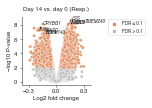

thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V3: number of regions with <= FDR 0.1: 74
thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V3: number of regions with <= FDR 0.1 UP: 54
thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V3: number of regions with <= FDR 0.1 DOWN: 20
(-0.3677209294067134, 0.3356398631913865)


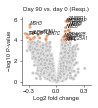

thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R: number of regions with <= FDR 0.1: 63
thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R: number of regions with <= FDR 0.1 UP: 32
thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R: number of regions with <= FDR 0.1 DOWN: 31
(-0.5465267361465349, 0.7256523521773429)


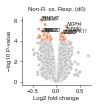

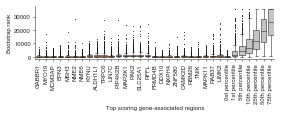

Using this peak annotation: ../data/DE/peaks_filtered_PBMC.csv.gz
thm.adaptive_MTB_7d_V3_FC1.2_R.V2: number of regions with <= FDR 0.1: 3709
thm.adaptive_MTB_7d_V3_FC1.2_R.V2: number of regions with <= FDR 0.1 UP: 2484
thm.adaptive_MTB_7d_V3_FC1.2_R.V2: number of regions with <= FDR 0.1 DOWN: 1225
(-0.3240229138108392, 0.3423790987237961)


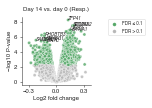

thm.adaptive_MTB_7d_V3_FC1.2_R.V3: number of regions with <= FDR 0.1: 0
thm.adaptive_MTB_7d_V3_FC1.2_R.V3: number of regions with <= FDR 0.1 UP: 0
thm.adaptive_MTB_7d_V3_FC1.2_R.V3: number of regions with <= FDR 0.1 DOWN: 0
(-0.3478222389031416, 0.3572273983126207)


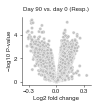

thm.adaptive_MTB_7d_V3_FC1.2_R: number of regions with <= FDR 0.1: 0
thm.adaptive_MTB_7d_V3_FC1.2_R: number of regions with <= FDR 0.1 UP: 0
thm.adaptive_MTB_7d_V3_FC1.2_R: number of regions with <= FDR 0.1 DOWN: 0
(-0.8912638553320269, 1.108834689137207)


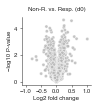

In [7]:
PREVIEW_TABLES = False

highlights = {
    'thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_N': ['MAPK11', 'PIK3R5', 'RAB37', 'CBLB', 'ST8SIA4'],
    'thm.innate_nonspecific_7448324h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V2': ['ADRM1', 'CASP8'],
    'thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V3': ['GABBR1', 'PIP4K2B', 'SLC25A1', 'NME2', 'NME6', 'MAP2K1', 'PAK2', 'RFFL']
}

for phenotype, color, xticks_list, xlim_list, legend_list, fig_ns in [
    ('innate_nonspecific_24h_wo_LAC_IL10_IL1ra', ORANGE,
     [[-0.3, 0, 0.3], [-0.3, 0, 0.3], [-0.5, 0, 0.5]],
     [[-0.375, 0.375], [-0.375, 0.375], [-0.73, 0.73]],
     [True, False, False],
     ['7B', '7C', '7D']),
    
    ('adaptive_MTB_7d', GREEN,
     [[-0.3, 0, 0.3], [-0.3, 0, 0.3], [-1, -0.5, 0, 0.5, 1]],
     [[-0.375, 0.375], [-0.375, 0.375], [-1.15, 1.15]],
     [True, False, False],
     ['7H', '7I', '7J']),
]:
    contrasts = get_phenotype_contrasts(phenotype, swap_to_non_resp=SWAP_TO_NON_RESP)
    de_df = misc.read_de(celltype=CELLTYPE, model=MODEL_TEMPLATE.format(phenotype), contrasts=contrasts.keys(), annot_fn=misc.PEAK_ANNOT_ALL_FN, swap_to_non_resp=SWAP_TO_NON_RESP)
    ranks = defaultdict(lambda: defaultdict(lambda: []))
    annots = {}
    for coef, with_bootstrap, xlim, xticks, legend, fig_n in zip(np.asarray(list(contrasts.keys()))[[1, 2, 0]], [False, True, True], xlim_list, xticks_list, legend_list, fig_ns):
        print('{}: number of regions with <= FDR {}: {}'.format(coef, np.min(ATAC_FDR), (de_df['padj.{}'.format(coef)] <= np.min(ATAC_FDR)).sum()))
        print('{}: number of regions with <= FDR {} UP: {}'.format(coef, np.min(ATAC_FDR), ((de_df['padj.{}'.format(coef)] <= np.min(ATAC_FDR)) & (de_df['Coef.{}'.format(coef)] > 0)).sum()))
        print('{}: number of regions with <= FDR {} DOWN: {}'.format(coef, np.min(ATAC_FDR), ((de_df['padj.{}'.format(coef)] <= np.min(ATAC_FDR)) & (de_df['Coef.{}'.format(coef)] < 0)).sum()))
        if PREVIEW_TABLES:
            display(de_df.sort_values(misc.pval_col(coef)).head(10)[[misc.coef_col(coef), misc.pval_col(coef), misc.padj_col(coef), 'chr', 'start', 'end', 'feat_anchor', 'distance', 'feat_type', 'characterization', 'gene_name']])

        # BOOTSTRAP HERE
        if N_BOOTS is not None and with_bootstrap and BOOTS_PHENOTYPE == phenotype:
            boots_de_fn = misc.de_fn(CELLTYPE, 'BS{bs}.' + MODEL_TEMPLATE.format(phenotype), data='results_p5', results_dir=BOOTS_DIR)
            s = utils.start_timing()
            for bs in range(1, N_BOOTS + 1):
                # df = pd.read_csv(boots_de_fn.format(bs=bs), usecols=[misc.pval_col(coef), misc.coef_col(coef)])
                df = misc.read_de(celltype=CELLTYPE, model=f'BS{bs}.' + MODEL_TEMPLATE.format(phenotype), contrasts=coef, results_dir=BOOTS_DIR, swap_to_non_resp=SWAP_TO_NON_RESP)
                for direction in [1, -1]:
                    ranks[coef][direction].append(df.loc[df[misc.coef_col(coef)] * direction > 0, misc.pval_col(coef)].rank(method='min').rename(f'ranks{bs}'))
            print(coef, utils.elapsed_time(s)) 
            for direction in ranks[coef]:
                ranks[coef][direction] = pd.concat(ranks[coef][direction], axis=1)
                ranks[coef][direction] = ranks[coef][direction].reindex(de_df.index)
                ranks[coef][direction] = ranks[coef][direction].where(~ranks[coef][direction].isnull(), other=ranks[coef][direction].max().max())
                
            ranks[coef] = pd.concat([ranks[coef][direction].loc[de_df[misc.coef_col(coef)] * direction > 0] for direction in [1, -1]])
        
        annots[coef] = misc.find_top_hits(
            de_df, coef, fdr=np.min(ATAC_FDR), show_n=5, unique_genes=True, highlights=highlights,
            region_filter=misc.GENE_AND_DISTAL_10kb,
            # model=MODEL_TEMPLATE.format(phenotype), celltype=CELLTYPE, top_n=TOP_N,
            # enr_fdr=np.min(FDR), library=['GO_Biological_Process_2018_min15_max500', 'KEGG_2019_Human_min15_max500']
        )
        if PREVIEW_TABLES:
            display(annots[coef][['gene_name', 'characterization', 'distance', 'feat_type', misc.pval_col(coef), misc.coef_col(coef), 'pathways']])
        
        ax = misc.volcano(de_df, contrasts=coef,
                          fdr=ATAC_FDR, fdr_with_hue=True, hue=None, sharex=False, sharey=True,
                          fdr_pass_color=color, fdr_fail_color=LIGHT_GRAY, rasterized=RASTER,
                          fdr_prefix='FDR ', legend_kwargs=dict(bbox_to_anchor=(1.8, 1), title=None, markerscale=None, fontsize=SMALL_FONT),
                          scatter_kwargs=dict(linewidth=CIRCLE_LINE_WIDTH),
                          figsize=FIG_SIZE, size=CIRCLE_SIZE * 0.5, alpha=ALPHA, legend=legend, centre=False,
                          on_top=annots[coef].index
                         )[0]
        misc.annotate_volcano(ax, annots[coef], coef)
        print(ax.get_xlim())
        assert (de_df[misc.coef_col(coef)] <= xlim[0]).sum() == 0
        assert (de_df[misc.coef_col(coef)] >= xlim[1]).sum() == 0
        ax.set_xlim(xlim)
        if xticks:
            ax.set_xticks(xticks)
        ax.set_title(contrasts[coef][0])
        
        if SAVE_FIG:
            utils.savefig(os.path.join(fig_dir, 'volcano_{}.{}.svg'.format(phenotype, coef)), dpi=DPI)
            annots[coef].to_csv(os.path.join(fig_dir, 'volcano_annot_{}_{}.csv'.format(phenotype, coef)))
        plt.show()
        
        if SAVE_TABLES:
            suppl_df = misc.suppl_table_atac_seq_LFC(de_df, coef, contrasts[coef][0], comparison_text=contrasts[coef][2], limit_top_n=SUPPL_LIMIT, enr_top_n=TOP_N, enr_rank_metric=RANK_METRIC, plot_enr_top_n_pvals=True,
                                                     suppl_tables=suppl_tables, sheet_name=f'{contrasts[coef][1]}_{SHORT_IMMUNITY_TYPES[phenotype]}', table_name=ATAC_V2_V3, fig_n=fig_n)
            suppl_df = misc.suppl_table_atac_seq_LFC(de_df, coef, contrasts[coef][0], comparison_text=contrasts[coef][2], limit_top_n=None, enr_top_n=None, enr_rank_metric=None, plot_enr_top_n_pvals=False,
                                                     suppl_tables=suppl_tables, sheet_name=f'{contrasts[coef][1]}_{SHORT_IMMUNITY_TYPES[phenotype]}', table_name=ATAC_V2_V3_FULL, fig_n='7')
            if PREVIEW_TABLES:
                display(suppl_df.head())
            
    if BOOTS_PHENOTYPE == phenotype:
        if N_BOOTS is not None:
            # pct_ranks for all coefficients
            pct_ranks = pd.concat([ranks[coef] for coef in ranks]).reset_index(drop=True)
            pct_examples = []
            for pct in BOOT_PCT_THRS:
                pct_examples.append((pct_ranks.median(axis=1).sort_values().rank(pct=True) - pct).abs().sort_values().index[0])

            ranks_df = pd.concat([ranks[coef].loc[annots[coef].index] for coef in ranks] + [pct_ranks.loc[pct_examples]])
            ranks_df.index = [g for coef in ranks for g in annots[coef]['gene_name']] + [f'{int(pct * 100):d}{"th" if pct > 0.03 else "st"} percentile' for pct in BOOT_PCT_THRS]
            ranks_df = ranks_df.stack().rename('rank')
            ranks_df.index.names = ['region', 'bootstrap']
            ranks_df = ranks_df.reset_index()
            ranks_df['hue'] = ranks_df['region'].str.endswith(' percentile')

            ranks_df.to_csv(os.path.join(fig_dir, 'bootstraps_{}.csv'.format(phenotype)))
        else:
            ranks_df = pd.read_csv(os.path.join(fig_dir, 'bootstraps_{}.csv'.format(phenotype)), index_col=0)
        
        fig, ax = plt.subplots(1, 1, figsize=(0.13 * len(ranks_df['region'].unique()), 0.97))
        ax = sns.boxplot(data=ranks_df, y='rank', x='region', hue='hue', orient='v',
                         flierprops=dict(markerfacecolor='k', marker='.', rasterized=RASTER,
                                         markersize=ERROR_FLIER_SIZE, markeredgewidth=0.0),
                         dodge=False, palette=['#e49d75', '#c5c5c5'], saturation=1)
        plt.setp(ax.artists, edgecolor='k', lw=0.5)
        plt.setp(ax.lines, color='k', lw=0.5)

        ax.set_ylabel('Bootstrap rank')
        ax.set_xlabel('Top scoring gene-associated regions')
        ax.set_yticks([0, 10000, 20000, 30000])
        ax.set_yticklabels(['0'] + [f'{x}' for x in [10000, 20000, 30000]])
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.legend(bbox_to_anchor=(1, 1), title='Reference').set_visible(False)
        sns.despine()
        if SAVE_FIG:
            utils.savefig(os.path.join(fig_dir, 'bootstraps_{}.svg'.format(phenotype)), dpi=DPI)
        plt.show()

### Genomic locations enrichments

In [8]:
peaks_df = misc.get_peak_annot(misc.PEAK_ANNOT_ALL_FN)

Using this peak annotation: ../data/DE/peaks_filtered_PBMC.csv.gz


In [9]:
genomic_enr = defaultdict(lambda: [])
for phenotype in [
    'innate_nonspecific_24h_wo_LAC_IL10_IL1ra',
    'adaptive_MTB_7d'
]:
    print(phenotype)
    contrasts = get_phenotype_contrasts(phenotype, swap_to_non_resp=SWAP_TO_NON_RESP)
    de_df = misc.read_de(celltype=CELLTYPE, model=MODEL_TEMPLATE.format(phenotype), contrasts=contrasts.keys(), peaks_df=peaks_df, swap_to_non_resp=SWAP_TO_NON_RESP)
    assert not de_df['characterization'].isnull().any()
    de_df = misc.simplify_peak_annot(de_df)
     
    for genomic_property, region_filter in [
        (GENOMIC_LOCATION_COL, None),
        (REGULATORY_ANNOT_COL, None),
        (FEATURE_TYPE_COL, misc.TSS_PROXIMAL)
    ]:
        if region_filter is not None:
            df = de_df.loc[de_df['characterization'].isin(misc.PEAKS_TO_GENES[region_filter]['location'])].copy()
        else:
            df = de_df.copy()

        for coef in contrasts.keys():
            for direction in DIRECTIONS.keys():
                top_regions = misc.get_top_n_regions(df, coef=coef, direction=direction, rank_metric=RANK_METRIC, top_n=TOP_N)
                assert len(top_regions) != 0
                counts = df.loc[top_regions, genomic_property].value_counts()
                counts = counts.reindex(misc.PEAK_FEATURE_ORDER[genomic_property])
                counts.loc[counts.isnull()] = 0
                assert counts.sum() == TOP_N, counts
                
                for category in counts.index:
                    odds_ratio, pval, overlap = fisher_enrichment(
                        regions1=top_regions,
                        regions2=df[df[genomic_property] == category].index,
                        universe=df.index
                    )
#                     immunoglobulin (IG) and T cell receptor
                    filter_suffix = ' promoters' if region_filter == misc.TSS_PROXIMAL else f' ({region_filter})' if region_filter is not None else ''
                    genomic_enr[phenotype].append(
                        [genomic_property, f'{category}{filter_suffix}',
                         contrasts[coef][0], DIRECTIONS[direction],
                         odds_ratio, pval, None, overlap]
                    )
                 
    index_cols = [GENOMIC_PROPERTY_COL, REGION_SET_COL, COMPARISON_COL, ASSOC_COL]
    genomic_enr[phenotype] = pd.DataFrame.from_records(
        genomic_enr[phenotype],
        columns=index_cols + ENR_COLS
    ).set_index(index_cols)
    print(f'Bonferroni correction of {len(genomic_enr[phenotype])}')
    genomic_enr[phenotype].loc[:, PADJ_COL] = np.clip(genomic_enr[phenotype][PVAL_COL].values * len(genomic_enr[phenotype]), a_min=None, a_max=1)
    display(genomic_enr[phenotype].sort_values(PVAL_COL).head())

innate_nonspecific_24h_wo_LAC_IL10_IL1ra
Bonferroni correction of 84


/home/lfolkman/miniconda3/envs/BCG/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


Odds ratio  \
Genomic property         Region set        Comparison               Association               
Genomic location         TSS proximal      Day 14 vs. day 0 (Resp.) Positive      17.351728   
                                           Day 90 vs. day 0 (Resp.) Positive      10.750169   
                                           Non-R. vs. Resp. (d0)    Positive       8.156930   
Ensembl Regulatory Build Promoter with TSS Day 14 vs. day 0 (Resp.) Positive       8.725448   
                                           Day 90 vs. day 0 (Resp.) Positive       7.373012   

                                                                                       P-value  \
Genomic property         Region set        Comparison               Association                  
Genomic location         TSS proximal      Day 14 vs. day 0 (Resp.) Positive      0.000000e+00   
                                           Day 90 vs. day 0 (Resp.) Positive     1.595640e-269   
                                           Non-R. vs. Resp. (d0)    Positive     4.620014e-220   
Ensembl Regulatory Build Promoter with TSS Day 14 vs. day 0 (Resp.) Positive     8.502917e-220   
                                           Day 90 vs. day 0 (Resp.) Positive     1.337547e-193   

                                                                                 Adjusted P-value  \
Genomic property         Region set        Comparison               Association                     
Genomic location         TSS proximal      Day 14 vs. day 0 (Resp.) Positive         0.000000e+00   
                                           Day 90 vs. day 0 (Resp.) Positive        1.340338e-267   
                                           Non-R. vs. Resp. (d0)    Positive        3.880812e-218   
Ensembl Regulatory Build Promoter with TSS Day 14 vs. day 0 (Resp.) Positive        7.142450e-218   
                                           Day 90 vs. day 0 (Resp.) Positive        1.123539e-191   

                                                                                   Overlap  
Genomic property         Region set        Comparison               Association             
Genomic location         TSS proximal      Day 14 vs. day 0 (Resp.) Positive     846/16011  
                                           Day 90 vs. day 0 (Resp.) Positive     774/16011  
                                           Non-R. vs. Resp. (d0)    Positive     723/16011  
Ensembl Regulatory Build Promoter with TSS Day 14 vs. day 0 (Resp.) Positive     789/19708  
                                           Day 90 vs. day 0 (Resp.) Positive     760/19708

adaptive_MTB_7d
Bonferroni correction of 84


/home/lfolkman/miniconda3/envs/BCG/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


Odds ratio  \
Genomic property         Region set        Comparison               Association               
Genomic location         TSS proximal      Day 14 vs. day 0 (Resp.) Positive      16.826636   
Ensembl Regulatory Build Promoter with TSS Day 14 vs. day 0 (Resp.) Positive       7.936376   
Genomic location         TSS proximal      Day 90 vs. day 0 (Resp.) Positive       3.686421   
Ensembl Regulatory Build Promoter with TSS Day 90 vs. day 0 (Resp.) Positive       3.266458   
                                           Day 14 vs. day 0 (Resp.) Negative       1.838304   

                                                                                       P-value  \
Genomic property         Region set        Comparison               Association                  
Genomic location         TSS proximal      Day 14 vs. day 0 (Resp.) Positive      0.000000e+00   
Ensembl Regulatory Build Promoter with TSS Day 14 vs. day 0 (Resp.) Positive     4.406446e-205   
Genomic location         TSS proximal      Day 90 vs. day 0 (Resp.) Positive      1.525673e-89   
Ensembl Regulatory Build Promoter with TSS Day 90 vs. day 0 (Resp.) Positive      1.812833e-75   
                                           Day 14 vs. day 0 (Resp.) Negative      7.439402e-21   

                                                                                 Adjusted P-value  \
Genomic property         Region set        Comparison               Association                     
Genomic location         TSS proximal      Day 14 vs. day 0 (Resp.) Positive         0.000000e+00   
Ensembl Regulatory Build Promoter with TSS Day 14 vs. day 0 (Resp.) Positive        3.701414e-203   
Genomic location         TSS proximal      Day 90 vs. day 0 (Resp.) Positive         1.281565e-87   
Ensembl Regulatory Build Promoter with TSS Day 90 vs. day 0 (Resp.) Positive         1.522780e-73   
                                           Day 14 vs. day 0 (Resp.) Negative         6.249098e-19   

                                                                                   Overlap  
Genomic property         Region set        Comparison               Association             
Genomic location         TSS proximal      Day 14 vs. day 0 (Resp.) Positive     842/16011  
Ensembl Regulatory Build Promoter with TSS Day 14 vs. day 0 (Resp.) Positive     773/19708  
Genomic location         TSS proximal      Day 90 vs. day 0 (Resp.) Positive     545/16011  
Ensembl Regulatory Build Promoter with TSS Day 90 vs. day 0 (Resp.) Positive     587/19708  
                                           Day 14 vs. day 0 (Resp.) Negative     447/19708

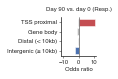

In [10]:
phenotype = 'innate_nonspecific_24h_wo_LAC_IL10_IL1ra'
coef = 'Day 90 vs. day 0 (Resp.)'
assert coef in genomic_enr[phenotype].index.get_level_values(COMPARISON_COL)
genomic_property = GENOMIC_LOCATION_COL
df = genomic_enr[phenotype].loc[(genomic_enr[phenotype].index.get_level_values(COMPARISON_COL) == coef) & (genomic_enr[phenotype].index.get_level_values(GENOMIC_PROPERTY_COL) == genomic_property)]
df, enr_name = misc.format_enrichment_for_plotting(df, main_col=COMPARISON_COL, main_col_direction=ASSOC_COL,
                                   col=REGION_SET_COL, extra_col=None,
                                   sort_lambda=lambda x: 0 if 'tss' in x.lower() else 1 if 'gene' in x.lower() else 2 if 'distal' in x.lower() else 3)

misc.plot_enrichment(df, direction_col=ASSOC_COL, comparison_col=REGION_SET_COL,
                value_col=ODDS_RATIO_COL, significance_col=PADJ_COL,
                significance_thr=np.min(FDR), force_directions=True,
                title=enr_name, xlabel=ODDS_RATIO_COL, sep_line=True,
                sep_line_kws=dict(c=rcParams['axes.edgecolor'], lw=rcParams['axes.linewidth']),
                figsize=(FIG_SIZE[0] / 2, FIG_SIZE[1] / 7 * 4), height=0.7295)
if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, 'peaks_{}.{}.svg'.format(phenotype, genomic_property)))

In [11]:
for phenotype in genomic_enr:
    suppl_enr[phenotype].append(genomic_enr[phenotype].copy())
    suppl_enr[phenotype][-1].index = pd.MultiIndex.from_arrays(
        [suppl_enr[phenotype][-1].index.get_level_values(0) + ': ' + suppl_enr[phenotype][-1].index.get_level_values(1),
         suppl_enr[phenotype][-1].index.get_level_values(2), suppl_enr[phenotype][-1].index.get_level_values(3)],
        names=[REGION_SET_COL, suppl_enr[phenotype][-1].index.names[2], suppl_enr[phenotype][-1].index.names[3]])
    display(suppl_enr[phenotype][-1])

,,,Odds ratio,P-value,Adjusted P-value,Overlap
Region set,Comparison,Association,,,,
Genomic location: TSS proximal,Non-R. vs. Resp. (d0),Negative,0.381771,1.000000e+00,1.000000e+00,114/16011
Genomic location: Gene body,Non-R. vs. Resp. (d0),Negative,1.779909,5.950615e-19,4.998517e-17,644/32432
Genomic location: Distal (< 10kb),Non-R. vs. Resp. (d0),Negative,0.878492,8.522990e-01,1.000000e+00,62/4475
Genomic location: Intergenic (≥ 10kb),Non-R. vs. Resp. (d0),Negative,1.042778,3.192765e-01,1.000000e+00,180/11147
Genomic location: TSS proximal,Non-R. vs. Resp. (d0),Positive,8.156930,4.620014e-220,3.880812e-218,723/16011
...,...,...,...,...,...,...
Genomic feature: LncRNA promoters,Day 90 vs. day 0 (Resp.),Negative,1.566601,5.827043e-09,4.894716e-07,254/2934
Genomic feature: Immunoglobulin (IG) and T-cell receptor (TR) promoters,Day 90 vs. day 0 (Resp.),Negative,1.072577,5.068525e-01,1.000000e+00,5/75
Genomic feature: Protein-coding promoters,Day 90 vs. day 0 (Resp.),Positive,2.000123,4.252546e-13,3.572138e-11,893/13002


,,,Odds ratio,P-value,Adjusted P-value,Overlap
Region set,Comparison,Association,,,,
Genomic location: TSS proximal,Non-R. vs. Resp. (d0),Negative,0.941723,7.992059e-01,1.000000e+00,239/16011
Genomic location: Gene body,Non-R. vs. Resp. (d0),Negative,1.048995,2.363791e-01,1.000000e+00,518/32432
Genomic location: Distal (< 10kb),Non-R. vs. Resp. (d0),Negative,0.909211,7.845927e-01,1.000000e+00,64/4475
Genomic location: Intergenic (≥ 10kb),Non-R. vs. Resp. (d0),Negative,1.035607,3.496457e-01,1.000000e+00,179/11147
Genomic location: TSS proximal,Non-R. vs. Resp. (d0),Positive,1.066596,1.964888e-01,1.000000e+00,262/16011
...,...,...,...,...,...,...
Genomic feature: LncRNA promoters,Day 90 vs. day 0 (Resp.),Negative,1.714226,1.844184e-12,1.549115e-10,270/2934
Genomic feature: Immunoglobulin (IG) and T-cell receptor (TR) promoters,Day 90 vs. day 0 (Resp.),Negative,1.798748,9.522193e-02,1.000000e+00,8/75
Genomic feature: Protein-coding promoters,Day 90 vs. day 0 (Resp.),Positive,1.782921,4.990333e-10,4.191879e-08,882/13002


### Cross-analysis enrichments

In [12]:
cross_enr = defaultdict(lambda: [])
for phenotype in [
        'innate_nonspecific_24h_wo_LAC_IL10_IL1ra',
        'adaptive_MTB_7d'
    ]:
    print(phenotype)
    contrasts = get_phenotype_contrasts(phenotype, swap_to_non_resp=SWAP_TO_NON_RESP)
    de_df = misc.read_de(celltype=CELLTYPE, model=MODEL_TEMPLATE.format(phenotype), contrasts=contrasts.keys(),
                         peaks_df=peaks_df, swap_to_non_resp=SWAP_TO_NON_RESP)
    for i, coef1 in enumerate(list(contrasts.keys())[:1]):
        for direction1 in DIRECTIONS.keys():
            for coef2 in list(contrasts.keys())[i + 1:]:
                for direction2 in DIRECTIONS.keys():
                    odds_ratio, pval, overlap = fisher_enrichment(
                        regions1=de_df.loc[de_df[coef_col(coef1)] * direction1 > 0, pval_col(coef1)].sort_values().head(TOP_N).index,
                        regions2=de_df.loc[de_df[coef_col(coef2)] * direction2 > 0, pval_col(coef2)].sort_values().head(TOP_N).index,
                        universe=de_df.index
                    )
                    cross_enr[phenotype].append(
                        [contrasts[coef1][0], DIRECTIONS[direction1],
                         contrasts[coef2][0], DIRECTIONS[direction2],
                         odds_ratio, pval, None, overlap]
                    )

    index_cols = [REGION_SET_COL, 'rs_association', COMPARISON_COL, ASSOC_COL]
    cross_enr[phenotype] = pd.DataFrame.from_records(
        cross_enr[phenotype],
        columns=index_cols + ENR_COLS
    ).set_index(index_cols)
    print(f'Bonferroni correction of {len(cross_enr[phenotype])}')
    cross_enr[phenotype].loc[:, PADJ_COL] = np.clip(cross_enr[phenotype][PVAL_COL].values * len(cross_enr[phenotype]), a_min=None, a_max=1)
    display(cross_enr[phenotype].sort_values(PVAL_COL))

innate_nonspecific_24h_wo_LAC_IL10_IL1ra
Bonferroni correction of 8


Odds ratio  \
Region set            rs_association Comparison               Association               
Non-R. vs. Resp. (d0) Positive       Day 14 vs. day 0 (Resp.) Positive      42.133468   
                                     Day 90 vs. day 0 (Resp.) Positive      19.751657   
                      Negative       Day 14 vs. day 0 (Resp.) Negative      16.529671   
                                     Day 90 vs. day 0 (Resp.) Negative       5.787714   
                                                              Positive       0.062190   
                                     Day 14 vs. day 0 (Resp.) Positive       0.000000   
                      Positive       Day 14 vs. day 0 (Resp.) Negative       0.000000   
                                     Day 90 vs. day 0 (Resp.) Negative       0.000000   

                                                                                 P-value  \
Region set            rs_association Comparison               Association                  
Non-R. vs. Resp. (d0) Positive       Day 14 vs. day 0 (Resp.) Positive      0.000000e+00   
                                     Day 90 vs. day 0 (Resp.) Positive     2.389726e-162   
                      Negative       Day 14 vs. day 0 (Resp.) Negative     2.075409e-133   
                                     Day 90 vs. day 0 (Resp.) Negative      6.864717e-32   
                                                              Positive      9.999999e-01   
                                     Day 14 vs. day 0 (Resp.) Positive      1.000000e+00   
                      Positive       Day 14 vs. day 0 (Resp.) Negative      1.000000e+00   
                                     Day 90 vs. day 0 (Resp.) Negative      1.000000e+00   

                                                                           Adjusted P-value  \
Region set            rs_association Comparison               Association                     
Non-R. vs. Resp. (d0) Positive       Day 14 vs. day 0 (Resp.) Positive         0.000000e+00   
                                     Day 90 vs. day 0 (Resp.) Positive        1.911780e-161   
                      Negative       Day 14 vs. day 0 (Resp.) Negative        1.660327e-132   
                                     Day 90 vs. day 0 (Resp.) Negative         5.491773e-31   
                                                              Positive         1.000000e+00   
                                     Day 14 vs. day 0 (Resp.) Positive         1.000000e+00   
                      Positive       Day 14 vs. day 0 (Resp.) Negative         1.000000e+00   
                                     Day 90 vs. day 0 (Resp.) Negative         1.000000e+00   

                                                                            Overlap  
Region set            rs_association Comparison               Association            
Non-R. vs. Resp. (d0) Positive       Day 14 vs. day 0 (Resp.) Positive     316/1000  
                                     Day 90 vs. day 0 (Resp.) Positive     202/1000  
                      Negative       Day 14 vs. day 0 (Resp.) Negative     179/1000  
                                     Day 90 vs. day 0 (Resp.) Negative      79/1000  
                                                              Positive       1/1000  
                                     Day 14 vs. day 0 (Resp.) Positive       0/1000  
                      Positive       Day 14 vs. day 0 (Resp.) Negative       0/1000  
                                     Day 90 vs. day 0 (Resp.) Negative       0/1000

adaptive_MTB_7d
Bonferroni correction of 8


Odds ratio  \
Region set            rs_association Comparison               Association               
Non-R. vs. Resp. (d0) Negative       Day 14 vs. day 0 (Resp.) Negative       5.111757   
                      Positive       Day 14 vs. day 0 (Resp.) Positive       2.550034   
                                     Day 90 vs. day 0 (Resp.) Positive       1.701704   
                      Negative       Day 90 vs. day 0 (Resp.) Negative       1.632873   
                      Positive       Day 90 vs. day 0 (Resp.) Negative       0.187326   
                                     Day 14 vs. day 0 (Resp.) Negative       0.062190   
                      Negative       Day 14 vs. day 0 (Resp.) Positive       0.000000   
                                     Day 90 vs. day 0 (Resp.) Positive       0.000000   

                                                                                P-value  \
Region set            rs_association Comparison               Association                 
Non-R. vs. Resp. (d0) Negative       Day 14 vs. day 0 (Resp.) Negative     5.692481e-26   
                      Positive       Day 14 vs. day 0 (Resp.) Positive     7.046266e-07   
                                     Day 90 vs. day 0 (Resp.) Positive     8.856574e-03   
                      Negative       Day 90 vs. day 0 (Resp.) Negative     1.571917e-02   
                      Positive       Day 90 vs. day 0 (Resp.) Negative     9.999810e-01   
                                     Day 14 vs. day 0 (Resp.) Negative     9.999999e-01   
                      Negative       Day 14 vs. day 0 (Resp.) Positive     1.000000e+00   
                                     Day 90 vs. day 0 (Resp.) Positive     1.000000e+00   

                                                                           Adjusted P-value  \
Region set            rs_association Comparison               Association                     
Non-R. vs. Resp. (d0) Negative       Day 14 vs. day 0 (Resp.) Negative         4.553985e-25   
                      Positive       Day 14 vs. day 0 (Resp.) Positive         5.637013e-06   
                                     Day 90 vs. day 0 (Resp.) Positive         7.085259e-02   
                      Negative       Day 90 vs. day 0 (Resp.) Negative         1.257533e-01   
                      Positive       Day 90 vs. day 0 (Resp.) Negative         1.000000e+00   
                                     Day 14 vs. day 0 (Resp.) Negative         1.000000e+00   
                      Negative       Day 14 vs. day 0 (Resp.) Positive         1.000000e+00   
                                     Day 90 vs. day 0 (Resp.) Positive         1.000000e+00   

                                                                           Overlap  
Region set            rs_association Comparison               Association           
Non-R. vs. Resp. (d0) Negative       Day 14 vs. day 0 (Resp.) Negative     71/1000  
                      Positive       Day 14 vs. day 0 (Resp.) Positive     38/1000  
                                     Day 90 vs. day 0 (Resp.) Positive     26/1000  
                      Negative       Day 90 vs. day 0 (Resp.) Negative     25/1000  
                      Positive       Day 90 vs. day 0 (Resp.) Negative      3/1000  
                                     Day 14 vs. day 0 (Resp.) Negative      1/1000  
                      Negative       Day 14 vs. day 0 (Resp.) Positive      0/1000  
                                     Day 90 vs. day 0 (Resp.) Positive      0/1000

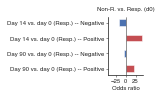

In [13]:
phenotype = 'innate_nonspecific_24h_wo_LAC_IL10_IL1ra'
df, enr_name = misc.format_enrichment_for_plotting(cross_enr[phenotype])

misc.plot_enrichment(df, direction_col='rs_association', comparison_col=COMPARISON_COL,
                value_col=ODDS_RATIO_COL, significance_col=PADJ_COL,
                significance_thr=np.min(FDR), force_directions=True,
                title=enr_name, xlabel=ODDS_RATIO_COL, sep_line=True,
                sep_line_kws=dict(c=rcParams['axes.edgecolor'], lw=rcParams['axes.linewidth']),
                figsize=(FIG_SIZE[0] / 2, FIG_SIZE[1] / 7 * 6), height=0.45)
if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, 'peak_contrast_overlaps.{}.svg'.format(phenotype)))

In [14]:
for phenotype in cross_enr:
    suppl_enr[phenotype].append(cross_enr[phenotype].copy())
    suppl_enr[phenotype][-1].index = pd.MultiIndex.from_arrays(
        [suppl_enr[phenotype][-1].index.get_level_values(0) + ': ' + suppl_enr[phenotype][-1].index.get_level_values(1),
         suppl_enr[phenotype][-1].index.get_level_values(2), suppl_enr[phenotype][-1].index.get_level_values(3)],
        names=[REGION_SET_COL, suppl_enr[phenotype][-1].index.names[2], suppl_enr[phenotype][-1].index.names[3]])
    display(suppl_enr[phenotype][-1])

Odds ratio  \
Region set                      Comparison               Association               
Non-R. vs. Resp. (d0): Negative Day 14 vs. day 0 (Resp.) Negative      16.529671   
                                                         Positive       0.000000   
                                Day 90 vs. day 0 (Resp.) Negative       5.787714   
                                                         Positive       0.062190   
Non-R. vs. Resp. (d0): Positive Day 14 vs. day 0 (Resp.) Negative       0.000000   
                                                         Positive      42.133468   
                                Day 90 vs. day 0 (Resp.) Negative       0.000000   
                                                         Positive      19.751657   

                                                                            P-value  \
Region set                      Comparison               Association                  
Non-R. vs. Resp. (d0): Negative Day 14 vs. day 0 (Resp.) Negative     2.075409e-133   
                                                         Positive      1.000000e+00   
                                Day 90 vs. day 0 (Resp.) Negative      6.864717e-32   
                                                         Positive      9.999999e-01   
Non-R. vs. Resp. (d0): Positive Day 14 vs. day 0 (Resp.) Negative      1.000000e+00   
                                                         Positive      0.000000e+00   
                                Day 90 vs. day 0 (Resp.) Negative      1.000000e+00   
                                                         Positive     2.389726e-162   

                                                                      Adjusted P-value  \
Region set                      Comparison               Association                     
Non-R. vs. Resp. (d0): Negative Day 14 vs. day 0 (Resp.) Negative        1.660327e-132   
                                                         Positive         1.000000e+00   
                                Day 90 vs. day 0 (Resp.) Negative         5.491773e-31   
                                                         Positive         1.000000e+00   
Non-R. vs. Resp. (d0): Positive Day 14 vs. day 0 (Resp.) Negative         1.000000e+00   
                                                         Positive         0.000000e+00   
                                Day 90 vs. day 0 (Resp.) Negative         1.000000e+00   
                                                         Positive        1.911780e-161   

                                                                       Overlap  
Region set                      Comparison               Association            
Non-R. vs. Resp. (d0): Negative Day 14 vs. day 0 (Resp.) Negative     179/1000  
                                                         Positive       0/1000  
                                Day 90 vs. day 0 (Resp.) Negative      79/1000  
                                                         Positive       1/1000  
Non-R. vs. Resp. (d0): Positive Day 14 vs. day 0 (Resp.) Negative       0/1000  
                                                         Positive     316/1000  
                                Day 90 vs. day 0 (Resp.) Negative       0/1000  
                                                         Positive     202/1000

Odds ratio  \
Region set                      Comparison               Association               
Non-R. vs. Resp. (d0): Negative Day 14 vs. day 0 (Resp.) Negative       5.111757   
                                                         Positive       0.000000   
                                Day 90 vs. day 0 (Resp.) Negative       1.632873   
                                                         Positive       0.000000   
Non-R. vs. Resp. (d0): Positive Day 14 vs. day 0 (Resp.) Negative       0.062190   
                                                         Positive       2.550034   
                                Day 90 vs. day 0 (Resp.) Negative       0.187326   
                                                         Positive       1.701704   

                                                                           P-value  \
Region set                      Comparison               Association                 
Non-R. vs. Resp. (d0): Negative Day 14 vs. day 0 (Resp.) Negative     5.692481e-26   
                                                         Positive     1.000000e+00   
                                Day 90 vs. day 0 (Resp.) Negative     1.571917e-02   
                                                         Positive     1.000000e+00   
Non-R. vs. Resp. (d0): Positive Day 14 vs. day 0 (Resp.) Negative     9.999999e-01   
                                                         Positive     7.046266e-07   
                                Day 90 vs. day 0 (Resp.) Negative     9.999810e-01   
                                                         Positive     8.856574e-03   

                                                                      Adjusted P-value  \
Region set                      Comparison               Association                     
Non-R. vs. Resp. (d0): Negative Day 14 vs. day 0 (Resp.) Negative         4.553985e-25   
                                                         Positive         1.000000e+00   
                                Day 90 vs. day 0 (Resp.) Negative         1.257533e-01   
                                                         Positive         1.000000e+00   
Non-R. vs. Resp. (d0): Positive Day 14 vs. day 0 (Resp.) Negative         1.000000e+00   
                                                         Positive         5.637013e-06   
                                Day 90 vs. day 0 (Resp.) Negative         1.000000e+00   
                                                         Positive         7.085259e-02   

                                                                      Overlap  
Region set                      Comparison               Association           
Non-R. vs. Resp. (d0): Negative Day 14 vs. day 0 (Resp.) Negative     71/1000  
                                                         Positive      0/1000  
                                Day 90 vs. day 0 (Resp.) Negative     25/1000  
                                                         Positive      0/1000  
Non-R. vs. Resp. (d0): Positive Day 14 vs. day 0 (Resp.) Negative      1/1000  
                                                         Positive     38/1000  
                                Day 90 vs. day 0 (Resp.) Negative      3/1000  
                                                         Positive     26/1000

### Baseline cytokine production capacity enrichments

In [15]:
df = misc.get_sample_annot()
immune_df = []
for protein in df.columns[df.columns.str.contains('^CYTO:.*_good$') | df.columns.str.contains('^CM:')]:
    model = 'V1.batch{covar}.blood.TSS_enr.visit_time.{protein}'.format(
        covar='.sex.age' if protein.startswith('CYTO:') else '.sex.age.bmi.oralContra',
        protein=misc.safe_R_name(protein))
    de_df = misc.read_de(CELLTYPE, model, contrasts=misc.safe_R_name(protein), swap_to_non_resp=SWAP_TO_NON_RESP)
    immune_df.append(misc.signed_log10_pvals(de_df, coef=misc.safe_R_name(protein)).rename(protein))
immune_df = pd.concat(immune_df, axis=1).T

In [16]:
PROTEIN_TOP_N = 100  # take top 100 regions for every cytokine --> roughly 2,000 regions for innate cytokines
# PROTEIN_TOP_N = 500  # taking 500 means roughly 8,000 regions for innate cytokines --> easier to get (potentially meaningless) enrichments
print('*** Number of top protein-associated regions:', PROTEIN_TOP_N, '***')

PHENO_SUBSETS = {
    'innate_nonspecific_24h_wo_LAC_IL10_IL1ra': {'CYTO': 'innate_24h_wo_LAC', 'CM': '^CM:'},
    'adaptive_MTB_7d': {'CYTO': 'adaptive_7d', 'CM': '^CM:'}
}

SUBSET_NAMES = {
    'innate_24h_wo_LAC': f'Innate {HUMAN_NAMES["CYTO"]} (d0)',
    'adaptive_7d': f'Adaptive {HUMAN_NAMES["CYTO"]} (d0)',
    '^CM:': f'{HUMAN_NAMES["CM"][0].upper()}{HUMAN_NAMES["CM"][1:].replace(" concentration", "")} (d0)'
}

protein_enr = defaultdict(lambda: defaultdict(lambda: []))
for phenotype in [
    'innate_nonspecific_24h_wo_LAC_IL10_IL1ra',
    'adaptive_MTB_7d'
]:
    for Y_name in [
        'CYTO',
        'CM'
    ]:
        subset = PHENO_SUBSETS[phenotype][Y_name]
        cytogroups = misc.get_fold_change_cytogroups_masks(immune_df.index)
        proteins = immune_df.index[cytogroups[subset] if subset in cytogroups else immune_df.index.str.contains(subset)]
        print('N proteins:', len(proteins))
        top_protein_hits = {1: pd.Index([]), -1: pd.Index([])}
        for protein in proteins:
            protein_pvals = immune_df.loc[protein].sort_values()
            top_protein_hits[1] = top_protein_hits[1].union(protein_pvals.tail(PROTEIN_TOP_N).index)
            top_protein_hits[-1] = top_protein_hits[-1].union(protein_pvals.head(PROTEIN_TOP_N).index)

        print('\n', phenotype, 'subset:', subset, '\n')
        print('DOWN {} regions: {}'.format(Y_name, len(top_protein_hits[-1])))
        print('UP {} regions: {}'.format(Y_name, len(top_protein_hits[1])))

        contrasts = get_phenotype_contrasts(phenotype, swap_to_non_resp=SWAP_TO_NON_RESP)
        de_df = misc.read_de(celltype=CELLTYPE, model=MODEL_TEMPLATE.format(phenotype), contrasts=contrasts.keys(), peaks_df=peaks_df, swap_to_non_resp=SWAP_TO_NON_RESP)

        for direction_protein in DIRECTIONS.keys():
            for coef in contrasts.keys():
                for direction_coef in DIRECTIONS.keys():
                    odds_ratio, pval, overlap = fisher_enrichment(
                        regions1=de_df.loc[de_df[coef_col(coef)] * direction_coef > 0, pval_col(coef)].sort_values().head(TOP_N).index,
                        regions2=top_protein_hits[direction_protein],
                        universe=de_df.index
                    )
                    protein_enr[phenotype][Y_name].append(
                        [SUBSET_NAMES[subset], DIRECTIONS[direction_protein],
                         contrasts[coef][0], DIRECTIONS[direction_coef],
                         odds_ratio, pval, None, overlap]
                    )

        index_cols = [REGION_SET_COL, 'rs_association', COMPARISON_COL, ASSOC_COL]
        protein_enr[phenotype][Y_name] = pd.DataFrame.from_records(
            protein_enr[phenotype][Y_name],
            columns=index_cols + ENR_COLS
        ).set_index(index_cols)
        print(f'Bonferroni correction of {len(protein_enr[phenotype][Y_name])}')
        protein_enr[phenotype][Y_name].loc[:, PADJ_COL] = np.clip(protein_enr[phenotype][Y_name][PVAL_COL].values * len(protein_enr[phenotype][Y_name]), a_min=None, a_max=1)
        display(protein_enr[phenotype][Y_name].sort_values(PVAL_COL).head())

*** Number of top protein-associated regions: 100 ***
N proteins: 24

 innate_nonspecific_24h_wo_LAC_IL10_IL1ra subset: innate_24h_wo_LAC 

DOWN CYTO regions: 2042
UP CYTO regions: 2002
Bonferroni correction of 12


Odds ratio  \
Region set                               rs_association Comparison               Association               
Innate cytokine production capacity (d0) Negative       Non-R. vs. Resp. (d0)    Negative       2.556185   
                                                        Day 90 vs. day 0 (Resp.) Negative       1.578885   
                                         Positive       Day 90 vs. day 0 (Resp.) Negative       1.263212   
                                         Negative       Day 14 vs. day 0 (Resp.) Negative       0.840740   
                                                        Day 90 vs. day 0 (Resp.) Positive       0.711794   

                                                                                                   P-value  \
Region set                               rs_association Comparison               Association                 
Innate cytokine production capacity (d0) Negative       Non-R. vs. Resp. (d0)    Negative     5.193115e-12   
                                                        Day 90 vs. day 0 (Resp.) Negative     2.289449e-03   
                                         Positive       Day 90 vs. day 0 (Resp.) Negative     9.505668e-02   
                                         Negative       Day 14 vs. day 0 (Resp.) Negative     8.351406e-01   
                                                        Day 90 vs. day 0 (Resp.) Positive     9.610205e-01   

                                                                                              Adjusted P-value  \
Region set                               rs_association Comparison               Association                     
Innate cytokine production capacity (d0) Negative       Non-R. vs. Resp. (d0)    Negative         6.231739e-11   
                                                        Day 90 vs. day 0 (Resp.) Negative         2.747339e-02   
                                         Positive       Day 90 vs. day 0 (Resp.) Negative         1.000000e+00   
                                         Negative       Day 14 vs. day 0 (Resp.) Negative         1.000000e+00   
                                                        Day 90 vs. day 0 (Resp.) Positive         1.000000e+00   

                                                                                              Overlap  
Region set                               rs_association Comparison               Association           
Innate cytokine production capacity (d0) Negative       Non-R. vs. Resp. (d0)    Negative     76/2042  
                                                        Day 90 vs. day 0 (Resp.) Negative     49/2042  
                                         Positive       Day 90 vs. day 0 (Resp.) Negative     39/2002  
                                         Negative       Day 14 vs. day 0 (Resp.) Negative     27/2042  
                                                        Day 90 vs. day 0 (Resp.) Positive     23/2042

N proteins: 73

 innate_nonspecific_24h_wo_LAC_IL10_IL1ra subset: ^CM: 

DOWN CM regions: 5165
UP CM regions: 4986
Bonferroni correction of 12


Odds ratio  \
Region set                rs_association Comparison               Association               
Inflammatory markers (d0) Positive       Non-R. vs. Resp. (d0)    Negative       2.005986   
                                         Day 90 vs. day 0 (Resp.) Negative       1.278226   
                          Negative       Day 14 vs. day 0 (Resp.) Negative       1.032701   
                                         Day 90 vs. day 0 (Resp.) Negative       1.018930   
                                                                  Positive       0.763856   

                                                                                    P-value  \
Region set                rs_association Comparison               Association                 
Inflammatory markers (d0) Positive       Non-R. vs. Resp. (d0)    Negative     1.411651e-12   
                                         Day 90 vs. day 0 (Resp.) Negative     1.522090e-02   
                          Negative       Day 14 vs. day 0 (Resp.) Negative     4.071083e-01   
                                         Day 90 vs. day 0 (Resp.) Negative     4.528148e-01   
                                                                  Positive     9.855187e-01   

                                                                               Adjusted P-value  \
Region set                rs_association Comparison               Association                     
Inflammatory markers (d0) Positive       Non-R. vs. Resp. (d0)    Negative         1.693981e-11   
                                         Day 90 vs. day 0 (Resp.) Negative         1.826508e-01   
                          Negative       Day 14 vs. day 0 (Resp.) Negative         1.000000e+00   
                                         Day 90 vs. day 0 (Resp.) Negative         1.000000e+00   
                                                                  Positive         1.000000e+00   

                                                                                Overlap  
Region set                rs_association Comparison               Association            
Inflammatory markers (d0) Positive       Non-R. vs. Resp. (d0)    Negative     143/4986  
                                         Day 90 vs. day 0 (Resp.) Negative      97/4986  
                          Negative       Day 14 vs. day 0 (Resp.) Negative      83/5165  
                                         Day 90 vs. day 0 (Resp.) Negative      82/5165  
                                                                  Positive      63/5165

N proteins: 4

 adaptive_MTB_7d subset: adaptive_7d 

DOWN CYTO regions: 395
UP CYTO regions: 397
Bonferroni correction of 12


Odds ratio  \
Region set                                 rs_association Comparison               Association               
Adaptive cytokine production capacity (d0) Positive       Non-R. vs. Resp. (d0)    Positive       4.321271   
                                           Negative       Non-R. vs. Resp. (d0)    Negative       4.155406   
                                                          Day 90 vs. day 0 (Resp.) Negative       1.306118   
                                           Positive       Day 90 vs. day 0 (Resp.) Positive       1.299361   
                                                                                   Negative       1.132866   

                                                                                                     P-value  \
Region set                                 rs_association Comparison               Association                 
Adaptive cytokine production capacity (d0) Positive       Non-R. vs. Resp. (d0)    Positive     5.904349e-09   
                                           Negative       Non-R. vs. Resp. (d0)    Negative     2.338568e-08   
                                                          Day 90 vs. day 0 (Resp.) Negative     2.778111e-01   
                                           Positive       Day 90 vs. day 0 (Resp.) Positive     2.822685e-01   
                                                                                   Negative     4.256157e-01   

                                                                                                Adjusted P-value  \
Region set                                 rs_association Comparison               Association                     
Adaptive cytokine production capacity (d0) Positive       Non-R. vs. Resp. (d0)    Positive         7.085219e-08   
                                           Negative       Non-R. vs. Resp. (d0)    Negative         2.806281e-07   
                                                          Day 90 vs. day 0 (Resp.) Negative         1.000000e+00   
                                           Positive       Day 90 vs. day 0 (Resp.) Positive         1.000000e+00   
                                                                                   Negative         1.000000e+00   

                                                                                               Overlap  
Region set                                 rs_association Comparison               Association          
Adaptive cytokine production capacity (d0) Positive       Non-R. vs. Resp. (d0)    Positive     25/397  
                                           Negative       Non-R. vs. Resp. (d0)    Negative     24/395  
                                                          Day 90 vs. day 0 (Resp.) Negative      8/395  
                                           Positive       Day 90 vs. day 0 (Resp.) Positive      8/397  
                                                                                   Negative      7/397

N proteins: 73

 adaptive_MTB_7d subset: ^CM: 

DOWN CM regions: 5165
UP CM regions: 4986
Bonferroni correction of 12


Odds ratio  \
Region set                rs_association Comparison               Association               
Inflammatory markers (d0) Positive       Day 90 vs. day 0 (Resp.) Negative       1.293122   
                          Negative       Day 14 vs. day 0 (Resp.) Negative       1.243603   
                                         Day 90 vs. day 0 (Resp.) Negative       1.158258   
                          Positive       Non-R. vs. Resp. (d0)    Negative       1.131385   
                                                                  Positive       1.131385   

                                                                                P-value  \
Region set                rs_association Comparison               Association             
Inflammatory markers (d0) Positive       Day 90 vs. day 0 (Resp.) Negative     0.011435   
                          Negative       Day 14 vs. day 0 (Resp.) Negative     0.026536   
                                         Day 90 vs. day 0 (Resp.) Negative     0.102989   
                          Positive       Non-R. vs. Resp. (d0)    Negative     0.151219   
                                                                  Positive     0.151219   

                                                                               Adjusted P-value  \
Region set                rs_association Comparison               Association                     
Inflammatory markers (d0) Positive       Day 90 vs. day 0 (Resp.) Negative             0.137216   
                          Negative       Day 14 vs. day 0 (Resp.) Negative             0.318437   
                                         Day 90 vs. day 0 (Resp.) Negative             1.000000   
                          Positive       Non-R. vs. Resp. (d0)    Negative             1.000000   
                                                                  Positive             1.000000   

                                                                               Overlap  
Region set                rs_association Comparison               Association           
Inflammatory markers (d0) Positive       Day 90 vs. day 0 (Resp.) Negative     98/4986  
                          Negative       Day 14 vs. day 0 (Resp.) Negative     98/5165  
                                         Day 90 vs. day 0 (Resp.) Negative     92/5165  
                          Positive       Non-R. vs. Resp. (d0)    Negative     87/4986  
                                                                  Positive     87/4986

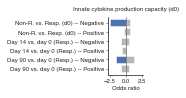

In [17]:
phenotype = 'innate_nonspecific_24h_wo_LAC_IL10_IL1ra'
Y_name = 'CYTO'
df, enr_name = misc.format_enrichment_for_plotting(protein_enr[phenotype][Y_name])

misc.plot_enrichment(df, direction_col='rs_association', comparison_col=COMPARISON_COL,
                value_col=ODDS_RATIO_COL, significance_col=PADJ_COL,
                significance_thr=np.min(FDR), force_directions=True,
                title=enr_name,
                xlabel=ODDS_RATIO_COL, sep_line=True,
                sep_line_kws=dict(c=rcParams['axes.edgecolor'], lw=rcParams['axes.linewidth']),
                figsize=(FIG_SIZE[0] / 2, FIG_SIZE[1] / 7 * 6), height=0.75)
if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, '{}.{}.top_per_protein{}.svg'.format(phenotype, Y_name, PROTEIN_TOP_N)))

In [18]:
for phenotype in protein_enr:
    for Y_name in protein_enr[phenotype]:
        suppl_enr[phenotype].append(protein_enr[phenotype][Y_name].copy())
        suppl_enr[phenotype][-1].index = pd.MultiIndex.from_arrays(
            [suppl_enr[phenotype][-1].index.get_level_values(0) + ': ' + suppl_enr[phenotype][-1].index.get_level_values(1),
             suppl_enr[phenotype][-1].index.get_level_values(2), suppl_enr[phenotype][-1].index.get_level_values(3)],
            names=[REGION_SET_COL, suppl_enr[phenotype][-1].index.names[2], suppl_enr[phenotype][-1].index.names[3]])
        display(suppl_enr[phenotype][-1])

Odds ratio  \
Region set                                         Comparison               Association               
Innate cytokine production capacity (d0): Negative Non-R. vs. Resp. (d0)    Negative       2.556185   
                                                                            Positive       0.365180   
                                                   Day 14 vs. day 0 (Resp.) Negative       0.840740   
                                                                            Positive       0.679802   
                                                   Day 90 vs. day 0 (Resp.) Negative       1.578885   
                                                                            Positive       0.711794   
Innate cytokine production capacity (d0): Positive Non-R. vs. Resp. (d0)    Negative       0.628957   
                                                                            Positive       0.661423   
                                                   Day 14 vs. day 0 (Resp.) Negative       0.564320   
                                                                            Positive       0.030547   
                                                   Day 90 vs. day 0 (Resp.) Negative       1.263212   
                                                                            Positive       0.500078   

                                                                                              P-value  \
Region set                                         Comparison               Association                 
Innate cytokine production capacity (d0): Negative Non-R. vs. Resp. (d0)    Negative     5.193115e-12   
                                                                            Positive     9.999868e-01   
                                                   Day 14 vs. day 0 (Resp.) Negative     8.351406e-01   
                                                                            Positive     9.753660e-01   
                                                   Day 90 vs. day 0 (Resp.) Negative     2.289449e-03   
                                                                            Positive     9.610205e-01   
Innate cytokine production capacity (d0): Positive Non-R. vs. Resp. (d0)    Negative     9.885927e-01   
                                                                            Positive     9.805901e-01   
                                                   Day 14 vs. day 0 (Resp.) Negative     9.966120e-01   
                                                                            Positive     1.000000e+00   
                                                   Day 90 vs. day 0 (Resp.) Negative     9.505668e-02   
                                                                            Positive     9.991951e-01   

                                                                                         Adjusted P-value  \
Region set                                         Comparison               Association                     
Innate cytokine production capacity (d0): Negative Non-R. vs. Resp. (d0)    Negative         6.231739e-11   
                                                                            Positive         1.000000e+00   
                                                   Day 14 vs. day 0 (Resp.) Negative         1.000000e+00   
                                                                            Positive         1.000000e+00   
                                                   Day 90 vs. day 0 (Resp.) Negative         2.747339e-02   
                                                                            Positive         1.000000e+00   
Innate cytokine production capacity (d0): Positive Non-R. vs. Resp. (d0)    Negative         1.000000e+00   
                                                                            Positive         1.000000e+00   
                                                   Day 14 vs. day 0 (Resp.) Negative 

Odds ratio  \
Region set                          Comparison               Association               
Inflammatory markers (d0): Negative Non-R. vs. Resp. (d0)    Negative       0.446384   
                                                             Positive       0.634470   
                                    Day 14 vs. day 0 (Resp.) Negative       1.032701   
                                                             Positive       0.288960   
                                    Day 90 vs. day 0 (Resp.) Negative       1.018930   
                                                             Positive       0.763856   
Inflammatory markers (d0): Positive Non-R. vs. Resp. (d0)    Negative       2.005986   
                                                             Positive       0.451184   
                                    Day 14 vs. day 0 (Resp.) Negative       0.753350   
                                                             Positive       0.739844   
                                    Day 90 vs. day 0 (Resp.) Negative       1.278226   
                                                             Positive       0.502487   

                                                                               P-value  \
Region set                          Comparison               Association                 
Inflammatory markers (d0): Negative Non-R. vs. Resp. (d0)    Negative     1.000000e+00   
                                                             Positive     9.997483e-01   
                                    Day 14 vs. day 0 (Resp.) Negative     4.071083e-01   
                                                             Positive     1.000000e+00   
                                    Day 90 vs. day 0 (Resp.) Negative     4.528148e-01   
                                                             Positive     9.855187e-01   
Inflammatory markers (d0): Positive Non-R. vs. Resp. (d0)    Negative     1.411651e-12   
                                                             Positive     1.000000e+00   
                                    Day 14 vs. day 0 (Resp.) Negative     9.877564e-01   
                                                             Positive     9.913109e-01   
                                    Day 90 vs. day 0 (Resp.) Negative     1.522090e-02   
                                                             Positive     9.999993e-01   

                                                                          Adjusted P-value  \
Region set                          Comparison               Association                     
Inflammatory markers (d0): Negative Non-R. vs. Resp. (d0)    Negative         1.000000e+00   
                                                             Positive         1.000000e+00   
                                    Day 14 vs. day 0 (Resp.) Negative         1.000000e+00   
                                                             Positive         1.000000e+00   
                                    Day 90 vs. day 0 (Resp.) Negative         1.000000e+00   
                                                             Positive         1.000000e+00   
Inflammatory markers (d0): Positive Non-R. vs. Resp. (d0)    Negative         1.693981e-11   
                                                             Positive         1.000000e+00   
                                    Day 14 vs. day 0 (Resp.) Negative         1.000000e+00   
                                                             Positive         1.000000e+00   
                                    Day 90 vs. day 0 (Resp.) Negative         1.826508e-01   
                                                             Positive         1.000000e+00   

                                                                           Overlap  
Region set                          Comparison               Association            
Inflammatory markers (d0): Negative Non-R. vs. Resp. (d0)    Negative      38/5165  
        

Odds ratio  \
Region set                                         Comparison               Association               
Adaptive cytokine production capacity (d0): Neg... Non-R. vs. Resp. (d0)    Negative       4.155406   
                                                                            Positive       0.319581   
                                                   Day 14 vs. day 0 (Resp.) Negative       0.481084   
                                                                            Positive       0.319581   
                                                   Day 90 vs. day 0 (Resp.) Negative       1.306118   
                                                                            Positive       0.807563   
Adaptive cytokine production capacity (d0): Pos... Non-R. vs. Resp. (d0)    Negative       0.640445   
                                                                            Positive       4.321271   
                                                   Day 14 vs. day 0 (Resp.) Negative       0.317952   
                                                                            Positive       0.803418   
                                                   Day 90 vs. day 0 (Resp.) Negative       1.132866   
                                                                            Positive       1.299361   

                                                                                              P-value  \
Region set                                         Comparison               Association                 
Adaptive cytokine production capacity (d0): Neg... Non-R. vs. Resp. (d0)    Negative     2.338568e-08   
                                                                            Positive     9.856690e-01   
                                                   Day 14 vs. day 0 (Resp.) Negative     9.468290e-01   
                                                                            Positive     9.856690e-01   
                                                   Day 90 vs. day 0 (Resp.) Negative     2.778111e-01   
                                                                            Positive     7.394983e-01   
Adaptive cytokine production capacity (d0): Pos... Non-R. vs. Resp. (d0)    Negative     8.683345e-01   
                                                                            Positive     5.904349e-09   
                                                   Day 14 vs. day 0 (Resp.) Negative     9.860545e-01   
                                                                            Positive     7.434390e-01   
                                                   Day 90 vs. day 0 (Resp.) Negative     4.256157e-01   
                                                                            Positive     2.822685e-01   

                                                                                         Adjusted P-value  \
Region set                                         Comparison               Association                     
Adaptive cytokine production capacity (d0): Neg... Non-R. vs. Resp. (d0)    Negative         2.806281e-07   
                                                                            Positive         1.000000e+00   
                                                   Day 14 vs. day 0 (Resp.) Negative         1.000000e+00   
                                                                            Positive         1.000000e+00   
                                                   Day 90 vs. day 0 (Resp.) Negative         1.000000e+00   
                                                                            Positive         1.000000e+00   
Adaptive cytokine production capacity (d0): Pos... Non-R. vs. Resp. (d0)    Negative         1.000000e+00   
                                                                            Positive         7.085219e-08   
                                                   Day 14 vs. day 0 (Resp.) Negative 

Odds ratio  \
Region set                          Comparison               Association               
Inflammatory markers (d0): Negative Non-R. vs. Resp. (d0)    Negative       0.991492   
                                                             Positive       0.950600   
                                    Day 14 vs. day 0 (Resp.) Negative       1.243603   
                                                             Positive       0.324841   
                                    Day 90 vs. day 0 (Resp.) Negative       1.158258   
                                                             Positive       0.883139   
Inflammatory markers (d0): Positive Non-R. vs. Resp. (d0)    Negative       1.131385   
                                                             Positive       1.131385   
                                    Day 14 vs. day 0 (Resp.) Negative       0.807718   
                                                             Positive       0.821397   
                                    Day 90 vs. day 0 (Resp.) Negative       1.293122   
                                                             Positive       0.780465   

                                                                           P-value  \
Region set                          Comparison               Association             
Inflammatory markers (d0): Negative Non-R. vs. Resp. (d0)    Negative     0.546020   
                                                             Positive     0.680892   
                                    Day 14 vs. day 0 (Resp.) Negative     0.026536   
                                                             Positive     1.000000   
                                    Day 90 vs. day 0 (Resp.) Negative     0.102989   
                                                             Positive     0.857818   
Inflammatory markers (d0): Positive Non-R. vs. Resp. (d0)    Negative     0.151219   
                                                             Positive     0.151219   
                                    Day 14 vs. day 0 (Resp.) Negative     0.958974   
                                                             Positive     0.946605   
                                    Day 90 vs. day 0 (Resp.) Negative     0.011435   
                                                             Positive     0.976864   

                                                                          Adjusted P-value  \
Region set                          Comparison               Association                     
Inflammatory markers (d0): Negative Non-R. vs. Resp. (d0)    Negative             1.000000   
                                                             Positive             1.000000   
                                    Day 14 vs. day 0 (Resp.) Negative             0.318437   
                                                             Positive             1.000000   
                                    Day 90 vs. day 0 (Resp.) Negative             1.000000   
                                                             Positive             1.000000   
Inflammatory markers (d0): Positive Non-R. vs. Resp. (d0)    Negative             1.000000   
                                                             Positive             1.000000   
                                    Day 14 vs. day 0 (Resp.) Negative             1.000000   
                                                             Positive             1.000000   
                                    Day 90 vs. day 0 (Resp.) Negative             0.137216   
                                                             Positive             1.000000   

                                                                          Overlap  
Region set                          Comparison               Association           
Inflammatory markers (d0): Negative Non-R. vs. Resp. (d0)    Negative     80/5165  
                                                             Positi

### Inflammation predicts responders? (No.)

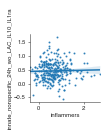

Mann-Whitney test: 0.08571712627937744


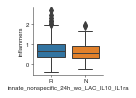

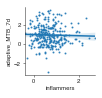

Mann-Whitney test: 0.198363925606787


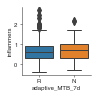

In [19]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from scipy.stats import mannwhitneyu

df = misc.get_sample_annot()
cm_df = df.loc[:, df.columns.str.contains('^CM:')]
cm_df = cm_df.loc[~cm_df.isnull().all(axis=1)]
cm_df = pd.DataFrame(
    data=StandardScaler().fit_transform(
        IterativeImputer(max_iter=10, random_state=misc.RANDOM_STATE).fit_transform(
            cm_df)),
    index=cm_df.index, columns=cm_df.columns
)
cm_df = cm_df.loc[cm_df.index.str.contains('_V1_')]

# top half mean
inflammers = cm_df.where((cm_df.T >= cm_df.median(axis=1)).T).mean(axis=1).rename('inflammers')

for phenotype in ['innate_nonspecific_24h_wo_LAC_IL10_IL1ra', 'adaptive_MTB_7d']:
    scores = df.loc[inflammers.index, 'thm.{}_V3'.format(phenotype)].rename(phenotype)
    plt.subplots(figsize=FIG_SIZE)
    sns.regplot(inflammers, scores, scatter_kws=dict(s=1))
    sns.despine()
    plt.show()
    
    responders = df.loc[inflammers.index, 'thm.{}_V3_FC1.2_responder'.format(phenotype)].rename(phenotype)
    print('Mann-Whitney test:', mannwhitneyu(inflammers.loc[responders == 'R'], inflammers.loc[responders == 'N'])[1])
    plt.subplots(figsize=FIG_SIZE)
    sns.boxplot(data=pd.concat([inflammers, responders], axis=1), y='inflammers', x=phenotype)
    sns.despine()
    plt.show()

### H3K27ac 28 days after BCG

In [20]:
H3K27ac_df = pd.read_csv(os.path.join(misc.METADATA, 'previous_work', 'Arts_CHM_2018_H3K27ac_DEseq_output.xlsx.hg38.matched_to_300BCG.csv'), index_col=0)
H3K27AC_TOP_N = 2000
H3K27ac_enr = defaultdict(lambda: [])
for phenotype in [
    'innate_nonspecific_24h_wo_LAC_IL10_IL1ra',
    'adaptive_MTB_7d'
]:
    print(phenotype)
    contrasts = get_phenotype_contrasts(phenotype, swap_to_non_resp=SWAP_TO_NON_RESP)
    de_df = misc.read_de(celltype=CELLTYPE, model=MODEL_TEMPLATE.format(phenotype), contrasts=contrasts.keys(), peaks_df=peaks_df, swap_to_non_resp=SWAP_TO_NON_RESP)
    for direction_H3K27ac in DIRECTIONS.keys():
        for coef in contrasts.keys():
            for direction_coef in DIRECTIONS.keys():
                H3K27ac_pvals = H3K27ac_df.loc[H3K27ac_df['log2FC'] * direction_H3K27ac > 0, 'pval'].sort_values()
                H3K27ac_pvals = H3K27ac_pvals.loc[~H3K27ac_pvals.index.duplicated()]
                odds_ratio, pval, overlap = fisher_enrichment(
                    regions1=de_df.loc[de_df[coef_col(coef)] * direction_coef > 0, pval_col(coef)].sort_values().head(TOP_N).index,
                    regions2=H3K27ac_pvals.head(H3K27AC_TOP_N).index,
                    universe=de_df.index
                )
                H3K27ac_enr[phenotype].append(
                    ['BCG-induced H3K27ac', DIRECTIONS[direction_H3K27ac],
                     contrasts[coef][0], DIRECTIONS[direction_coef],
                     odds_ratio, pval, None, overlap]
                )

    index_cols = [REGION_SET_COL, 'rs_association', COMPARISON_COL, ASSOC_COL]
    H3K27ac_enr[phenotype] = pd.DataFrame.from_records(
        H3K27ac_enr[phenotype],
        columns=index_cols + ENR_COLS
    ).set_index(index_cols)
    print(f'Bonferroni correction of {len(H3K27ac_enr[phenotype])}')
    H3K27ac_enr[phenotype].loc[:, PADJ_COL] = np.clip(H3K27ac_enr[phenotype][PVAL_COL].values * len(H3K27ac_enr[phenotype]), a_min=None, a_max=1)
    display(H3K27ac_enr[phenotype].sort_values(PVAL_COL))

innate_nonspecific_24h_wo_LAC_IL10_IL1ra
Bonferroni correction of 12


Odds ratio  \
Region set          rs_association Comparison               Association               
BCG-induced H3K27ac Positive       Day 14 vs. day 0 (Resp.) Positive       2.196217   
                                   Non-R. vs. Resp. (d0)    Positive       1.974461   
                                   Day 90 vs. day 0 (Resp.) Positive       1.937905   
                    Negative       Day 90 vs. day 0 (Resp.) Positive       1.264542   
                                   Day 14 vs. day 0 (Resp.) Negative       1.161802   
                                   Non-R. vs. Resp. (d0)    Positive       0.992670   
                                                            Negative       0.793119   
                                   Day 90 vs. day 0 (Resp.) Negative       0.727415   
                    Positive       Day 14 vs. day 0 (Resp.) Negative       0.727415   
                    Negative       Day 14 vs. day 0 (Resp.) Positive       0.694714   
                    Positive       Non-R. vs. Resp. (d0)    Negative       0.662114   
                                   Day 90 vs. day 0 (Resp.) Negative       0.662114   

                                                                              P-value  \
Region set          rs_association Comparison               Association                 
BCG-induced H3K27ac Positive       Day 14 vs. day 0 (Resp.) Positive     3.535791e-08   
                                   Non-R. vs. Resp. (d0)    Positive     3.305137e-06   
                                   Day 90 vs. day 0 (Resp.) Positive     6.628682e-06   
                    Negative       Day 90 vs. day 0 (Resp.) Positive     9.405620e-02   
                                   Day 14 vs. day 0 (Resp.) Negative     2.130937e-01   
                                   Non-R. vs. Resp. (d0)    Positive     5.414768e-01   
                                                            Negative     8.940914e-01   
                                   Day 90 vs. day 0 (Resp.) Negative     9.504301e-01   
                    Positive       Day 14 vs. day 0 (Resp.) Negative     9.504301e-01   
                    Negative       Day 14 vs. day 0 (Resp.) Positive     9.680872e-01   
                    Positive       Non-R. vs. Resp. (d0)    Negative     9.803352e-01   
                                   Day 90 vs. day 0 (Resp.) Negative     9.803352e-01   

                                                                         Adjusted P-value  \
Region set          rs_association Comparison               Association                     
BCG-induced H3K27ac Positive       Day 14 vs. day 0 (Resp.) Positive         4.242949e-07   
                                   Non-R. vs. Resp. (d0)    Positive         3.966164e-05   
                                   Day 90 vs. day 0 (Resp.) Positive         7.954418e-05   
                    Negative       Day 90 vs. day 0 (Resp.) Positive         1.000000e+00   
                                   Day 14 vs. day 0 (Resp.) Negative         1.000000e+00   
                                   Non-R. vs. Resp. (d0)    Positive         1.000000e+00   
                                                            Negative         1.000000e+00   
                                   Day 90 vs. day 0 (Resp.) Negative         1.000000e+00   
                    Positive       Day 14 vs. day 0 (Resp.) Negative         1.000000e+00   
                    Negative       Day 14 vs. day 0 (Resp.) Positive         1.000000e+00   
                    Positive       Non-R. vs. Resp. (d0)    Negative         1.000000e+00   
                                   Day 90 vs. day 0 (Resp.) Negative         1.000000e+00   

                                                                         Overlap  
Region set          rs_association Comparison               Association           
BCG-induced H3K27ac Positive       Day 14 vs. day 0 (Resp.) Positive     65/2000  
                                   Non-R. vs. Resp. (d0

adaptive_MTB_7d
Bonferroni correction of 12


Odds ratio  \
Region set          rs_association Comparison               Association               
BCG-induced H3K27ac Positive       Day 14 vs. day 0 (Resp.) Positive       2.121835   
                    Negative       Day 14 vs. day 0 (Resp.) Negative       1.685183   
                                   Day 90 vs. day 0 (Resp.) Positive       1.543225   
                    Positive       Day 90 vs. day 0 (Resp.) Positive       1.264542   
                    Negative       Non-R. vs. Resp. (d0)    Negative       0.925744   
                    Positive       Non-R. vs. Resp. (d0)    Negative       0.925744   
                                                            Positive       0.925744   
                                   Day 14 vs. day 0 (Resp.) Negative       0.826123   
                    Negative       Day 14 vs. day 0 (Resp.) Positive       0.564908   
                    Positive       Day 90 vs. day 0 (Resp.) Negative       0.564908   
                    Negative       Non-R. vs. Resp. (d0)    Positive       0.532704   
                                   Day 90 vs. day 0 (Resp.) Negative       0.436680   

                                                                              P-value  \
Region set          rs_association Comparison               Association                 
BCG-induced H3K27ac Positive       Day 14 vs. day 0 (Resp.) Positive     1.716806e-07   
                    Negative       Day 14 vs. day 0 (Resp.) Negative     5.181367e-04   
                                   Day 90 vs. day 0 (Resp.) Positive     4.091970e-03   
                    Positive       Day 90 vs. day 0 (Resp.) Positive     9.405620e-02   
                    Negative       Non-R. vs. Resp. (d0)    Negative     6.833243e-01   
                    Positive       Non-R. vs. Resp. (d0)    Negative     6.833243e-01   
                                                            Positive     6.833243e-01   
                                   Day 14 vs. day 0 (Resp.) Negative     8.536474e-01   
                    Negative       Day 14 vs. day 0 (Resp.) Positive     9.965580e-01   
                    Positive       Day 90 vs. day 0 (Resp.) Negative     9.965580e-01   
                    Negative       Non-R. vs. Resp. (d0)    Positive     9.982700e-01   
                                   Day 90 vs. day 0 (Resp.) Negative     9.998488e-01   

                                                                         Adjusted P-value  \
Region set          rs_association Comparison               Association                     
BCG-induced H3K27ac Positive       Day 14 vs. day 0 (Resp.) Positive             0.000002   
                    Negative       Day 14 vs. day 0 (Resp.) Negative             0.006218   
                                   Day 90 vs. day 0 (Resp.) Positive             0.049104   
                    Positive       Day 90 vs. day 0 (Resp.) Positive             1.000000   
                    Negative       Non-R. vs. Resp. (d0)    Negative             1.000000   
                    Positive       Non-R. vs. Resp. (d0)    Negative             1.000000   
                                                            Positive             1.000000   
                                   Day 14 vs. day 0 (Resp.) Negative             1.000000   
                    Negative       Day 14 vs. day 0 (Resp.) Positive             1.000000   
                    Positive       Day 90 vs. day 0 (Resp.) Negative             1.000000   
                    Negative       Non-R. vs. Resp. (d0)    Positive             1.000000   
                                   Day 90 vs. day 0 (Resp.) Negative             1.000000   

                                                                         Overlap  
Region set          rs_association Comparison               Association           
BCG-induced H3K27ac Positive       Day 14 vs. day 0 (Resp.) Positive     63/2000  
                    Negative       Day 14 vs. day 0 (Re

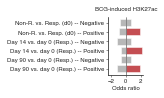

In [21]:
phenotype = 'innate_nonspecific_24h_wo_LAC_IL10_IL1ra'
df, enr_name = misc.format_enrichment_for_plotting(H3K27ac_enr[phenotype])

misc.plot_enrichment(df, direction_col='rs_association', comparison_col=COMPARISON_COL,
                value_col=ODDS_RATIO_COL, significance_col=PADJ_COL,
                significance_thr=np.min(FDR), force_directions=True,
                title=enr_name, xlabel=ODDS_RATIO_COL, sep_line=True,
                sep_line_kws=dict(c=rcParams['axes.edgecolor'], lw=rcParams['axes.linewidth']),
                figsize=(FIG_SIZE[0] / 2, FIG_SIZE[1] / 7 * 6), height=0.75)
if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, 'H3K27ac_BCG_{}.svg'.format(phenotype)))

In [22]:
for phenotype in H3K27ac_enr:
    suppl_enr[phenotype].append(H3K27ac_enr[phenotype].copy())
    suppl_enr[phenotype][-1].index = pd.MultiIndex.from_arrays(
        [suppl_enr[phenotype][-1].index.get_level_values(0) + ': ' + suppl_enr[phenotype][-1].index.get_level_values(1),
         suppl_enr[phenotype][-1].index.get_level_values(2), suppl_enr[phenotype][-1].index.get_level_values(3)],
        names=[REGION_SET_COL, suppl_enr[phenotype][-1].index.names[2], suppl_enr[phenotype][-1].index.names[3]])
    display(suppl_enr[phenotype][-1])

Odds ratio  \
Region set                    Comparison               Association               
BCG-induced H3K27ac: Negative Non-R. vs. Resp. (d0)    Negative       0.793119   
                                                       Positive       0.992670   
                              Day 14 vs. day 0 (Resp.) Negative       1.161802   
                                                       Positive       0.694714   
                              Day 90 vs. day 0 (Resp.) Negative       0.727415   
                                                       Positive       1.264542   
BCG-induced H3K27ac: Positive Non-R. vs. Resp. (d0)    Negative       0.662114   
                                                       Positive       1.974461   
                              Day 14 vs. day 0 (Resp.) Negative       0.727415   
                                                       Positive       2.196217   
                              Day 90 vs. day 0 (Resp.) Negative       0.662114   
                                                       Positive       1.937905   

                                                                         P-value  \
Region set                    Comparison               Association                 
BCG-induced H3K27ac: Negative Non-R. vs. Resp. (d0)    Negative     8.940914e-01   
                                                       Positive     5.414768e-01   
                              Day 14 vs. day 0 (Resp.) Negative     2.130937e-01   
                                                       Positive     9.680872e-01   
                              Day 90 vs. day 0 (Resp.) Negative     9.504301e-01   
                                                       Positive     9.405620e-02   
BCG-induced H3K27ac: Positive Non-R. vs. Resp. (d0)    Negative     9.803352e-01   
                                                       Positive     3.305137e-06   
                              Day 14 vs. day 0 (Resp.) Negative     9.504301e-01   
                                                       Positive     3.535791e-08   
                              Day 90 vs. day 0 (Resp.) Negative     9.803352e-01   
                                                       Positive     6.628682e-06   

                                                                    Adjusted P-value  \
Region set                    Comparison               Association                     
BCG-induced H3K27ac: Negative Non-R. vs. Resp. (d0)    Negative         1.000000e+00   
                                                       Positive         1.000000e+00   
                              Day 14 vs. day 0 (Resp.) Negative         1.000000e+00   
                                                       Positive         1.000000e+00   
                              Day 90 vs. day 0 (Resp.) Negative         1.000000e+00   
                                                       Positive         1.000000e+00   
BCG-induced H3K27ac: Positive Non-R. vs. Resp. (d0)    Negative         1.000000e+00   
                                                       Positive         3.966164e-05   
                              Day 14 vs. day 0 (Resp.) Negative         1.000000e+00   
                                                       Positive         4.242949e-07   
                              Day 90 vs. day 0 (Resp.) Negative         1.000000e+00   
                                                       Positive         7.954418e-05   

                                                                    Overlap  
Region set                    Comparison               Association           
BCG-induced H3K27ac: Negative Non-R. vs. Resp. (d0)    Negative     25/2000  
                                                       Positive     31/2000  
                              Day 14 vs. day 0 (Resp.) Negative     36/2000  
                                                       Positive     22/2000  
                              Day 90 vs. 

Odds ratio  \
Region set                    Comparison               Association               
BCG-induced H3K27ac: Negative Non-R. vs. Resp. (d0)    Negative       0.925744   
                                                       Positive       0.532704   
                              Day 14 vs. day 0 (Resp.) Negative       1.685183   
                                                       Positive       0.564908   
                              Day 90 vs. day 0 (Resp.) Negative       0.436680   
                                                       Positive       1.543225   
BCG-induced H3K27ac: Positive Non-R. vs. Resp. (d0)    Negative       0.925744   
                                                       Positive       0.925744   
                              Day 14 vs. day 0 (Resp.) Negative       0.826123   
                                                       Positive       2.121835   
                              Day 90 vs. day 0 (Resp.) Negative       0.564908   
                                                       Positive       1.264542   

                                                                         P-value  \
Region set                    Comparison               Association                 
BCG-induced H3K27ac: Negative Non-R. vs. Resp. (d0)    Negative     6.833243e-01   
                                                       Positive     9.982700e-01   
                              Day 14 vs. day 0 (Resp.) Negative     5.181367e-04   
                                                       Positive     9.965580e-01   
                              Day 90 vs. day 0 (Resp.) Negative     9.998488e-01   
                                                       Positive     4.091970e-03   
BCG-induced H3K27ac: Positive Non-R. vs. Resp. (d0)    Negative     6.833243e-01   
                                                       Positive     6.833243e-01   
                              Day 14 vs. day 0 (Resp.) Negative     8.536474e-01   
                                                       Positive     1.716806e-07   
                              Day 90 vs. day 0 (Resp.) Negative     9.965580e-01   
                                                       Positive     9.405620e-02   

                                                                    Adjusted P-value  \
Region set                    Comparison               Association                     
BCG-induced H3K27ac: Negative Non-R. vs. Resp. (d0)    Negative             1.000000   
                                                       Positive             1.000000   
                              Day 14 vs. day 0 (Resp.) Negative             0.006218   
                                                       Positive             1.000000   
                              Day 90 vs. day 0 (Resp.) Negative             1.000000   
                                                       Positive             0.049104   
BCG-induced H3K27ac: Positive Non-R. vs. Resp. (d0)    Negative             1.000000   
                                                       Positive             1.000000   
                              Day 14 vs. day 0 (Resp.) Negative             1.000000   
                                                       Positive             0.000002   
                              Day 90 vs. day 0 (Resp.) Negative             1.000000   
                                                       Positive             1.000000   

                                                                    Overlap  
Region set                    Comparison               Association           
BCG-induced H3K27ac: Negative Non-R. vs. Resp. (d0)    Negative     29/2000  
                                                       Positive     17/2000  
                              Day 14 vs. day 0 (Resp.) Negative     51/2000  
                                                       Positive     18/2000  
                              Day 90 vs. 

In [23]:
if SAVE_TABLES:
    for phenotype in suppl_enr:
        suppl_df = pd.concat(suppl_enr[phenotype])
        misc.suppl_table_enrich_LFC_extras(suppl_df, phenotype, suppl_tables=suppl_tables, table_name=ENRICH_V2_V3_LOLA, fig_n='7E-G and S5C')

### Gene set and region set enrichments

enrichr GO_Biological_Process_2018 1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R 2.675429411688797e-06
enrichr GO_Biological_Process_2018 1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V2 3.554406035594684e-06
enrichr GO_Biological_Process_2018 1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V3 2.675429411688797e-06
enrichr GO_Biological_Process_2018 -1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R 1.3039954663935387e-06
enrichr GO_Biological_Process_2018 -1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V2 9.312298814999001e-05
enrichr GO_Biological_Process_2018 -1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V3 0.0009067747421150127


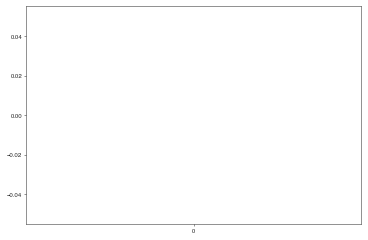

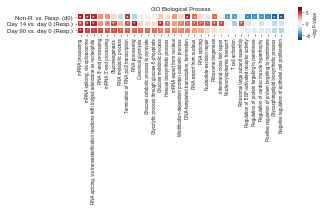

enrichr GO_Biological_Process_2018 1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R 2.675429411688797e-06
enrichr GO_Biological_Process_2018 1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V2 3.554406035594684e-06
enrichr GO_Biological_Process_2018 1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V3 2.675429411688797e-06
enrichr GO_Biological_Process_2018 -1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R 1.3039954663935387e-06
enrichr GO_Biological_Process_2018 -1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V2 9.312298814999001e-05
enrichr GO_Biological_Process_2018 -1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V3 0.0009067747421150127


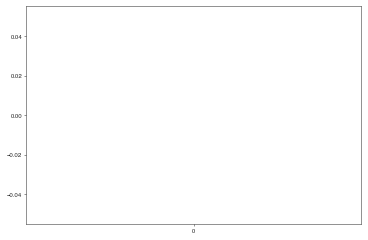

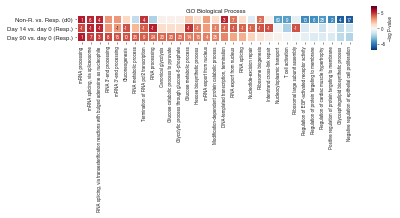

enrichr KEGG_2019_Human 1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R 0.0003538127679828041
enrichr KEGG_2019_Human 1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V2 0.00027105737094548635
enrichr KEGG_2019_Human 1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V3 0.003045988414458976
enrichr KEGG_2019_Human -1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R 1.33474180475062e-05
enrichr KEGG_2019_Human -1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V2 2.8301005799699156e-05
enrichr KEGG_2019_Human -1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V3 0.003693238250927225


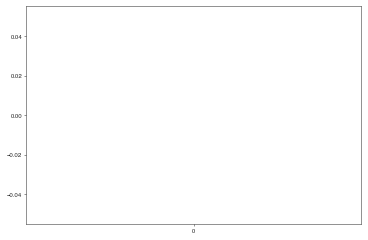

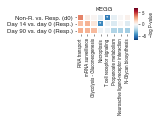

Some terms were enriched both positively and negatively!!!
Only the stronger direction will be displayed: {'monocarboxylic acid metabolic process (GO:0032787)'}
enrichr GO_Biological_Process_2018 1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R 7.390755424926992e-05
enrichr GO_Biological_Process_2018 1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V2 1.667484145245692e-05
enrichr GO_Biological_Process_2018 1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V3 1.4338239124613243e-06
enrichr GO_Biological_Process_2018 -1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R 3.2465082330743253e-06
enrichr GO_Biological_Process_2018 -1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V2 1.1416228292902439e-07
enrichr GO_Biological_Process_2018 -1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V3 0.0003447171729445573


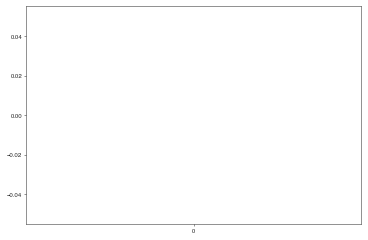

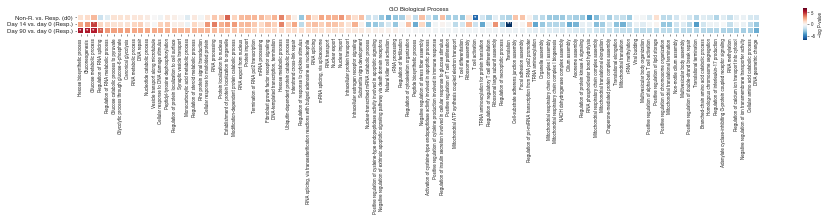

Some terms were enriched both positively and negatively!!!
Only the stronger direction will be displayed: {'Non-alcoholic fatty liver disease (NAFLD)', 'Alzheimer disease', 'RNA transport', 'Spliceosome', 'Oxidative phosphorylation'}
enrichr KEGG_2019_Human 1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R 0.02146751782798336
enrichr KEGG_2019_Human 1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V2 0.0020646519199787982
enrichr KEGG_2019_Human 1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V3 0.0020646519199787982
enrichr KEGG_2019_Human -1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R 0.0023671578747632357
enrichr KEGG_2019_Human -1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V2 0.006351004397550347
enrichr KEGG_2019_Human -1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V3 0.012607979697479605


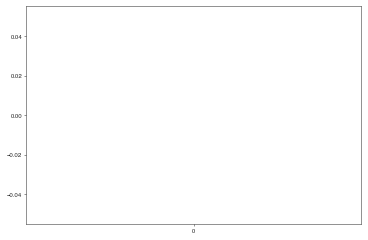

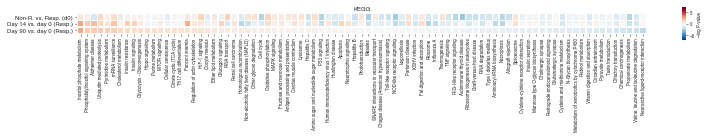

Some terms were enriched both positively and negatively!!!
Only the stronger direction will be displayed: {'PBX1', 'ETV4', 'ETV2', 'BRAC', 'EHF', 'OTX2', 'E2F5', 'P53', 'TFAP4', 'CREM', 'HSF2', 'ERR3', 'ELK1', 'STAT3', 'ZFP42', 'RXRG', 'STAT1', 'TAL1', 'STAT4', 'ELF1', 'ATF1', 'ZN680', 'ELK4', 'NFYC', 'NR1H3', 'RFX3', 'ETV1', 'NDF2', 'ZN264', 'HSF1', 'NDF1', 'NKX28', 'PRD14', 'BCL6', 'SPIB', 'ETV5', 'ZN708', 'SPI1', 'ZN418', 'NFYA', 'ETS2', 'CREB1', 'ZN382', 'CUX1', 'ELF2', 'STAT6', 'ELF5', 'ZIC3', 'ZNF18', 'NFAC3', 'ELF3', 'HIF1A', 'STA5A', 'ERG', 'NR4A1', 'NFAC4', 'GABPA', 'ZN582', 'PEBB', 'NFYB', 'ETS1', 'GCR', 'MYOG', 'NFAC2', 'MYB'}
lola HOCOMOCO_v11 1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R 9.195592142374044e-237
lola HOCOMOCO_v11 1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V2 2.2250738585072014e-308
lola HOCOMOCO_v11 1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V3 3.578358143360942e-195
lola HOCOMOCO_v11 -1 thm.innate_nonspecific_24h_wo

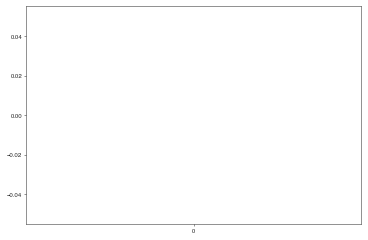

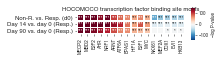

Some terms were enriched both positively and negatively!!!
Only the stronger direction will be displayed: {'H3K27ac', 'H3K27me3', 'H3K4me3', 'H3K9ac', 'H3K36me3', 'H3K9me3', 'H3K4me1'}
lola Roadmap_Epigenomics_r9 1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R 1.0290653254028002e-248
lola Roadmap_Epigenomics_r9 1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V2 2.2250738585072014e-308
lola Roadmap_Epigenomics_r9 1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V3 5.2272721954273085e-261
lola Roadmap_Epigenomics_r9 -1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R 0.009037255363453987
lola Roadmap_Epigenomics_r9 -1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V2 6.178143076203324e-141
lola Roadmap_Epigenomics_r9 -1 thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_R.V3 1.504851018406518e-85


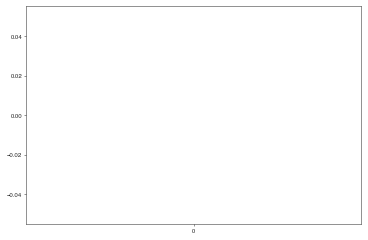

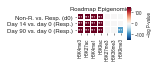

enrichr GO_Biological_Process_2018 1 thm.adaptive_MTB_7d_V3_FC1.2_R 0.00023696273337855118
enrichr GO_Biological_Process_2018 1 thm.adaptive_MTB_7d_V3_FC1.2_R.V2 1.9593791250868272e-08
enrichr GO_Biological_Process_2018 1 thm.adaptive_MTB_7d_V3_FC1.2_R.V3 3.0678593875925704e-05
enrichr GO_Biological_Process_2018 -1 thm.adaptive_MTB_7d_V3_FC1.2_R 2.1872109314889995e-05
enrichr GO_Biological_Process_2018 -1 thm.adaptive_MTB_7d_V3_FC1.2_R.V2 1.5198833582931916e-05
enrichr GO_Biological_Process_2018 -1 thm.adaptive_MTB_7d_V3_FC1.2_R.V3 0.0004026271547803306


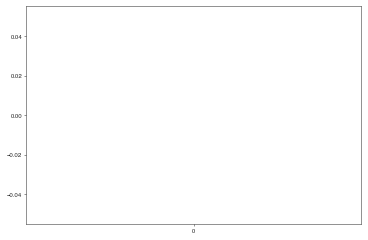

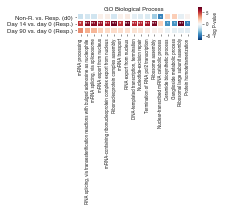

enrichr KEGG_2019_Human 1 thm.adaptive_MTB_7d_V3_FC1.2_R 0.0005519956753211392
enrichr KEGG_2019_Human 1 thm.adaptive_MTB_7d_V3_FC1.2_R.V2 0.00010899120073268664
enrichr KEGG_2019_Human 1 thm.adaptive_MTB_7d_V3_FC1.2_R.V3 0.012531916205793673
enrichr KEGG_2019_Human -1 thm.adaptive_MTB_7d_V3_FC1.2_R 0.00027105737094548635
enrichr KEGG_2019_Human -1 thm.adaptive_MTB_7d_V3_FC1.2_R.V2 0.00395255042343728
enrichr KEGG_2019_Human -1 thm.adaptive_MTB_7d_V3_FC1.2_R.V3 0.02154576388089584


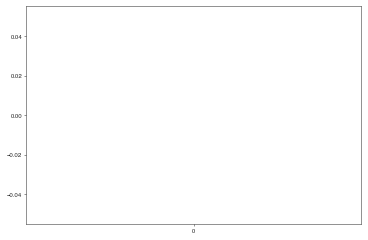

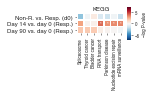

Some terms were enriched both positively and negatively!!!
Only the stronger direction will be displayed: {'metal ion transport (GO:0030001)', 'RNA processing (GO:0006396)', 'monovalent inorganic cation transport (GO:0015672)', 'mRNA splicing, via spliceosome (GO:0000398)', 'potassium ion transport (GO:0006813)', 'ribonucleoprotein complex assembly (GO:0022618)'}
enrichr GO_Biological_Process_2018 1 thm.adaptive_MTB_7d_V3_FC1.2_R 1.1599404062349801e-07
enrichr GO_Biological_Process_2018 1 thm.adaptive_MTB_7d_V3_FC1.2_R.V2 1.1443196544325473e-05
enrichr GO_Biological_Process_2018 1 thm.adaptive_MTB_7d_V3_FC1.2_R.V3 0.0008310893309015495
enrichr GO_Biological_Process_2018 -1 thm.adaptive_MTB_7d_V3_FC1.2_R 2.2810662849506947e-07
enrichr GO_Biological_Process_2018 -1 thm.adaptive_MTB_7d_V3_FC1.2_R.V2 2.93846555799912e-06
enrichr GO_Biological_Process_2018 -1 thm.adaptive_MTB_7d_V3_FC1.2_R.V3 6.569254218332662e-05


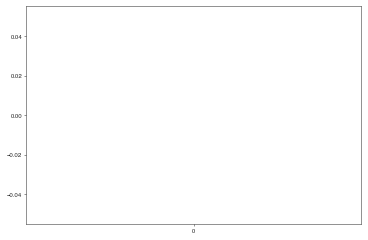

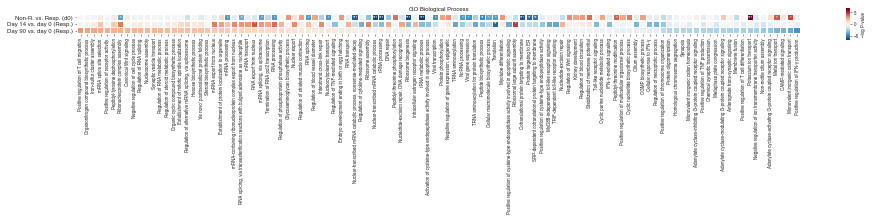

Some terms were enriched both positively and negatively!!!
Only the stronger direction will be displayed: {'RNA transport', 'Fanconi anemia pathway', 'Spliceosome', 'Alzheimer disease'}
enrichr KEGG_2019_Human 1 thm.adaptive_MTB_7d_V3_FC1.2_R 0.0006201894466576544
enrichr KEGG_2019_Human 1 thm.adaptive_MTB_7d_V3_FC1.2_R.V2 0.0020646519199787982
enrichr KEGG_2019_Human 1 thm.adaptive_MTB_7d_V3_FC1.2_R.V3 0.0006470800055067776
enrichr KEGG_2019_Human -1 thm.adaptive_MTB_7d_V3_FC1.2_R 4.655355823349046e-07
enrichr KEGG_2019_Human -1 thm.adaptive_MTB_7d_V3_FC1.2_R.V2 0.00024796070533846475
enrichr KEGG_2019_Human -1 thm.adaptive_MTB_7d_V3_FC1.2_R.V3 4.027834360254961e-05


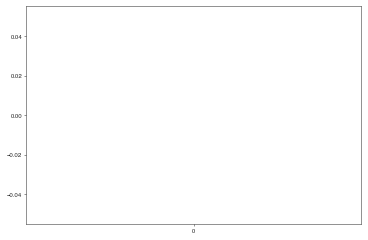

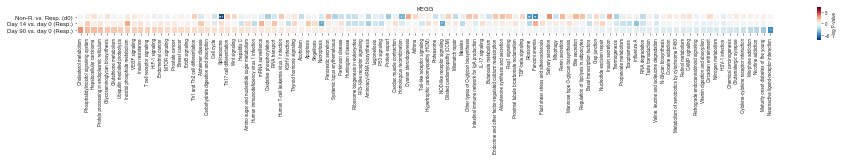

Some terms were enriched both positively and negatively!!!
Only the stronger direction will be displayed: {'IRF8', 'ETV4', 'PPARA', 'P53', 'ZN335', 'TFAP4', 'NFE2', 'IRF1', 'BACH1', 'STAT2', 'IRF7', 'E2F6', 'ELF1', 'ITF2', 'ATF1', 'HTF4', 'ZEB1', 'NR1D1', 'ZBT17', 'OVOL1', 'NFAC1', 'NR2C2', 'IRF9', 'ZN667', 'LEF1', 'ZN708', 'NR6A1', 'ZFP28', 'ZN143', 'RORA', 'PBX3', 'KLF5', 'GLI3', 'STAT6', 'PPARG', 'ZIC3', 'HIC1', 'PKNX1', 'TAF1', 'STF1', 'CRX', 'MAZ', 'REST', 'NFYB', 'BHA15', 'SOX3', 'IRF4', 'ZNF76', 'SP2', 'ERR3', 'GATA4', 'SIX2', 'ELK1', 'STAT3', 'BMAL1', 'SOX2', 'SP1', 'E2F1', 'STAT4', 'CTCFL', 'ZN680', 'KLF9', 'ELK4', 'ZN449', 'ZSC31', 'ATOH1', 'NRF1', 'KLF15', 'NR1H3', 'ETV1', 'RFX3', 'HEN1', 'ZN264', 'MXI1', 'PRDM1', 'BCL6', 'SPI1', 'VEZF1', 'ZBT48', 'COE1', 'SP4', 'ZN563', 'PAX6', 'NR2C1', 'PRDM6', 'ZNF18', 'HNF4A', 'KLF8', 'ZN547', 'IRF3', 'NR1H4', 'ZN341', 'GABPA', 'KLF3', 'ETS1', 'MYOD1', 'VDR', 'CTCF', 'ZN467', 'STA5B', 'ZN549', 'FOXI1', 'MZF1', 'E2F3', 'PBX1', 'EHF', 'ZFP

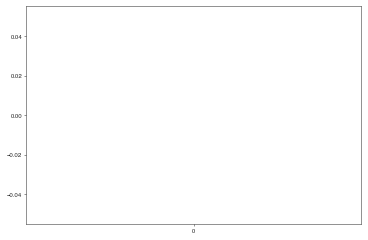

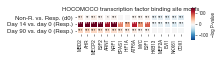

Some terms were enriched both positively and negatively!!!
Only the stronger direction will be displayed: {'H3K27ac', 'H3K27me3', 'H3K4me3', 'H3K9ac', 'H3K36me3', 'H3K9me3', 'H3K4me1'}
lola Roadmap_Epigenomics_r9 1 thm.adaptive_MTB_7d_V3_FC1.2_R 8.503967920573962e-17
lola Roadmap_Epigenomics_r9 1 thm.adaptive_MTB_7d_V3_FC1.2_R.V2 2.2250738585072014e-308
lola Roadmap_Epigenomics_r9 1 thm.adaptive_MTB_7d_V3_FC1.2_R.V3 3.644666608911518e-89
lola Roadmap_Epigenomics_r9 -1 thm.adaptive_MTB_7d_V3_FC1.2_R 0.10090399770996998
lola Roadmap_Epigenomics_r9 -1 thm.adaptive_MTB_7d_V3_FC1.2_R.V2 1.9232926191431105e-72
lola Roadmap_Epigenomics_r9 -1 thm.adaptive_MTB_7d_V3_FC1.2_R.V3 1.0145005584125478e-70


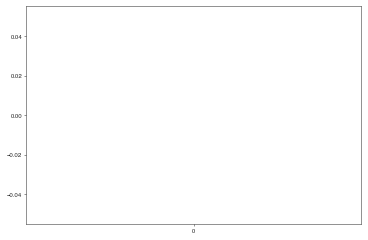

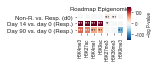

In [24]:
for phenotype in [
    'innate_nonspecific_24h_wo_LAC_IL10_IL1ra',
    'adaptive_MTB_7d'
]:
    contrasts = get_phenotype_contrasts(phenotype, swap_to_non_resp=SWAP_TO_NON_RESP)
    suppl_dict = defaultdict(lambda: defaultdict(lambda: {}))
    
    GO_top_n = {
        f'thm.{phenotype}_V3_FC1.2_R': (np.min(FDR), 8, 8),
        f'thm.{phenotype}_V3_FC1.2_R.V2': (np.min(FDR), 13, 13),
        f'thm.{phenotype}_V3_FC1.2_R.V3': (np.min(FDR), 16, 16)
    }
    
    KEGG_top_n = {
        f'thm.{phenotype}_V3_FC1.2_R': np.min(FDR),
        f'thm.{phenotype}_V3_FC1.2_R.V2': np.min(FDR),
        f'thm.{phenotype}_V3_FC1.2_R.V3': (0.99, 4, 3)
    }
    
    JASPAR_top_n = {
        f'thm.{phenotype}_V3_FC1.2_R': (np.min(FDR), 0, 30),
        f'thm.{phenotype}_V3_FC1.2_R.V2': (np.min(FDR), 0, 0),
        f'thm.{phenotype}_V3_FC1.2_R.V3': (np.min(FDR), 0, 30)
    }
    
    HOCOMOCO_top_n = {
        f'thm.{phenotype}_V3_FC1.2_R': (np.min(FDR), 0, 30),
        f'thm.{phenotype}_V3_FC1.2_R.V2': (np.min(FDR), 0, 0),
        f'thm.{phenotype}_V3_FC1.2_R.V3': (np.min(FDR), 0, 30)
    }
    
    selected_TFs = set(['MECP2', 'MBD2', 'E2F2', 'AHR', 'E2F1', 'NRF1', 'ARNT', 'ATF6A', 'EPAS1', 'HIF1A', 'MYC', 'NKX61', 'HXB13', 'EVI1', 'CDX1', 'MEF2A'])
    for method, library, region_filter, force_index, vmax, vmin, pthw_fdr_or_top_n, sort_by_n_column, with_bootstrap in [
        ('enrichr', misc.GO_BIO_PROCESS, misc.GENE_AND_DISTAL_10kb, None, ENR_VMAX, ENR_VMIN, GO_top_n, -1, ['R', 'R.V3']),
        ('enrichr', misc.KEGG, misc.GENE_AND_DISTAL_10kb, None, ENR_VMAX, ENR_VMIN, KEGG_top_n, -1, False),
        ('enrichr', misc.GO_BIO_PROCESS, misc.TSS_PROXIMAL, None, ENR_VMAX, ENR_VMIN, 20, -1, False),
        ('enrichr', misc.KEGG, misc.TSS_PROXIMAL, None, ENR_VMAX, ENR_VMIN, 20, -1, False),
        ('lola', HOCOMOCO, None, selected_TFs if phenotype == 'innate_nonspecific_24h_wo_LAC_IL10_IL1ra' else selected_TFs,
         LOLA_VMAX, LOLA_VMIN, np.min(FDR) if phenotype == 'innate_nonspecific_24h_wo_LAC_IL10_IL1ra' else np.min(FDR), 'special', False),
        ('lola', EPI_ROADMAP, None, None, LOLA_VMAX, LOLA_VMIN, 20, -1, False),
        # # ('lola', 'leukotypes', None, ['Monocyte', 'Nkcell', 'Cd4t', 'Cd8t', 'Bcell', 'Erythroblast', 'GMP', 'CMP', 'CLP', 'HSC', 'LMPP', 'MEP', 'MPP'], None, None, 20, -1, False)
    ]:
        ax, results, enr_df = misc.enr_heatmap(
            celltype=CELLTYPE, model=MODEL_TEMPLATE.format(phenotype), contrasts=contrasts.keys(),
            method=method, library='{}{}'.format(library, '_min15_max500' if library in [misc.KEGG, misc.GO_BIO_PROCESS] else ''), top_n=TOP_N, region_filter=region_filter,
            pthw_fdr_or_top_n=pthw_fdr_or_top_n, pval_asterisks=PVAL_ASTERISKS,
            sort_by_n_column=sort_by_n_column,
            sort_ascending=False, force_index=force_index,
            fmt='.0e', annot_size=SMALL_FONT, rename_pthw=True, swap_to_non_resp=SWAP_TO_NON_RESP,
            transpose=TRANSPOSE_ENR_TABLE, fig_width=ENR_FIG_WIDTH, cell_height=ENR_CELL_HEIGHT,
            heatmap_kws=dict(vmax=vmax, vmin=vmin, lw=0.5),
            cbar_kws=dict(shrink=0.2, aspect=8, orientation='vertical'),
            save_fig=False, show_fig=False, fig_format='svg')
        
        print('\n'.join([f'{method} {library} {d} {c} {enr_df[d][c]["P-value"].min()}' for d in enr_df for c in enr_df[d]]))
        ax.tick_params(axis='x', labelsize=SMALL_FONT)
        ax.set_yticklabels([contrasts[p][0] for p in contrasts])
        ax.collections[0].colorbar.ax.set_ylabel('{}log P-value'.format(utils.MINUS), fontsize=SMALL_FONT)
        ax.collections[0].colorbar.ax.tick_params(axis='both', which='both', labelsize=SMALL_FONT)
        ax.set_title(LIB_TO_NAME.get(library, library), pad=3)
        if SAVE_FIG:
            utils.savefig(os.path.join(fig_dir, 'enr_{}_{}_{}.svg'.format(library, MODEL_TEMPLATE.format(phenotype), region_filter)), dpi=DPI)
        plt.show()
        
        if SAVE_TABLES:
            suppl_dict[method][region_filter][library] = enr_df.copy()
        
        # NOW WITH BOOTSTRAPS
        if with_bootstrap and phenotype == BOOTS_PHENOTYPE:
            if N_BOOTS is not None:
                ranks = defaultdict(lambda: defaultdict(lambda: []))
                pthws = defaultdict(lambda: {})
                for bs in range(1, N_BOOTS + 1):
                    for coef in results['oddsratio'].index[::-1]:
                        if any([coef.endswith(c) for c in with_bootstrap]):
                            for direction in [1, -1]:
                                boots_enr_fn = misc.enrichr_fn(
                                    CELLTYPE, f'BS{bs}.' + MODEL_TEMPLATE.format(phenotype), data='results',
                                    coef=coef, effect_size_filter=None, rank_metric=RANK_METRIC, top_n=TOP_N,
                                    direction=direction, db=None, regions=BOOTS_REGIONS, results_dir=BOOTS_DIR,
                                    swap_to_non_resp=SWAP_TO_NON_RESP)
                                df = pd.read_csv(boots_enr_fn, sep='\t')
                                df = df.loc[df['Gene_set'] == f'{library}_min15_max500'].set_index('Term')['P-value'].rank(method='min').rename(f'ranks{bs}')
                                df.index = df.index.str.replace(' \(GO:[0-9]*\)', '')
                                df.index = rename_pathways(df.index)
                                ranks[coef][direction].append(df)
                for coef in ranks:
                    for direction in ranks[coef]:
                        ranks[coef][direction] = pd.concat(ranks[coef][direction], axis=1)
                        ranks[coef][direction] = ranks[coef][direction].where(~ranks[coef][direction].isnull(), other=ranks[coef][direction].max().max())
                        pws = results['pval'].loc[coef, results['padj'].loc[coef] < 0.05]
                        pthws[coef][direction] = pws.loc[pws * direction > 0]

                median_ranked_ranks = {}
                for direction in [1, -1]:
                    median_ranked_ranks[direction] = pd.concat([ranks[coef][direction].median(axis=1).rank(method='min').rename(coef) for coef in ranks], axis=1).T
                    median_ranked_ranks[direction] = median_ranked_ranks[direction].loc[:, results['oddsratio'].columns]
                    median_ranked_ranks[direction] = median_ranked_ranks[direction].reindex(results['oddsratio'].index).fillna(-1)

                results['bootstraps'] = median_ranked_ranks[1].copy()
                results['bootstraps'] = results['bootstraps'].where(results['oddsratio'] > 0, other=median_ranked_ranks[-1])
                utils.dump_pickle(os.path.join(fig_dir, 'enr_{}_{}_{}_bootstrap.pkl'.format(library, MODEL_TEMPLATE.format(phenotype), region_filter)), results['bootstraps'])
                
                # pct_ranks for all coefficients
                pct_ranks = pd.concat([ranks[coef][direction] for coef in ranks for direction in ranks[coef]]).reset_index(drop=True)
                pct_examples = []
                for pct in BOOT_PCT_THRS:
                    closeness = (pct_ranks.median(axis=1).sort_values().rank(pct=True) - pct).abs()
                    pct_examples.append(closeness.index[closeness == closeness.min()][0 if pct == 0.01 else -1])
                pct_ranks = pct_ranks.loc[pct_examples]
                pct_ranks.index = [f'{int(pct * 100):d}{"th" if pct > 0.03 else "st"} percentile' for pct in BOOT_PCT_THRS]

                ranks_df = pd.concat([ranks[coef][direction].loc[pthws[coef][direction].abs().sort_values(ascending=False).index] for coef in ranks for direction in ranks[coef]] + [pct_ranks])
                ranks_df['hue'] = [x for xx in [[direction] * len(pthws[coef][direction]) for coef in ranks for direction in ranks[coef]] + [[0] * len(pct_ranks)] for x in xx]
                ranks_df['coef'] = [x.split('_')[-1] for xx in [[coef] * len(pthws[coef][direction]) for coef in ranks for direction in ranks[coef]] + [['pct'] * len(pct_ranks)] for x in xx]
                ranks_df = ranks_df.set_index(['hue', 'coef'], append=True)
                ranks_df = ranks_df.stack().rename('rank')
                ranks_df.index.names = ['pathway', 'hue', 'coef', 'bootstrap']
                ranks_df = ranks_df.reset_index()
                ranks_df['pathway_coef'] = ranks_df['pathway'] + ' (' + ranks_df['coef'] + ')'
                ranks_df.to_csv(os.path.join(fig_dir, 'enr_{}_{}_{}_bootstrap.csv'.format(library, MODEL_TEMPLATE.format(phenotype), region_filter)))
                
            else:
                results['bootstraps'] = utils.load_pickle(os.path.join(fig_dir, 'enr_{}_{}_{}_bootstrap.pkl'.format(library, MODEL_TEMPLATE.format(phenotype), region_filter)))

            ax, results, enr_df = misc.enr_heatmap(
                annot=results['bootstraps'].astype(int).where(results['padj'] <= 0.05, other='').T,
                celltype=CELLTYPE, model=MODEL_TEMPLATE.format(phenotype), contrasts=contrasts.keys(),
                method=method, library='{}{}'.format(library, '_min15_max500' if library in [misc.KEGG, misc.GO_BIO_PROCESS] else ''), top_n=TOP_N, region_filter=region_filter,
                pthw_fdr_or_top_n=pthw_fdr_or_top_n, pval_asterisks=PVAL_ASTERISKS,
                sort_by_n_column=sort_by_n_column,
                sort_ascending=False, force_index=force_index,
                fmt='.0e', annot_size=SMALL_FONT, rename_pthw=True, swap_to_non_resp=SWAP_TO_NON_RESP,
                transpose=TRANSPOSE_ENR_TABLE, fig_width=ENR_FIG_WIDTH + 1, cell_height=ENR_CELL_HEIGHT + 0.05,
                heatmap_kws=dict(vmax=vmax, vmin=vmin, lw=0.5),
                cbar_kws=dict(shrink=0.2, aspect=8, orientation='vertical'),
                save_fig=False, show_fig=False, fig_format='svg')

            print('\n'.join([f'{method} {library} {d} {c} {enr_df[d][c]["P-value"].min()}' for d in enr_df for c in enr_df[d]]))
            ax.tick_params(axis='x', labelsize=SMALL_FONT)
            ax.set_yticklabels([contrasts[p][0] for p in contrasts])
            ax.collections[0].colorbar.ax.set_ylabel('{}log P-value'.format(utils.MINUS), fontsize=SMALL_FONT)
            ax.collections[0].colorbar.ax.tick_params(axis='both', which='both', labelsize=SMALL_FONT)
            ax.set_title(LIB_TO_NAME.get(library, library), pad=3)
            if SAVE_FIG:
                utils.savefig(os.path.join(fig_dir, 'enr_{}_{}_{}_bootstrap.svg'.format(library, MODEL_TEMPLATE.format(phenotype), region_filter)), dpi=DPI)
            plt.show()

    for method, region_filter, table_name, fig_n in [
        ('enrichr', misc.GENE_AND_DISTAL_10kb, ENRICH_V2_V3, '7K'),
        ('enrichr', misc.TSS_PROXIMAL, ENRICH_V2_V3_PROMOTERS, None),
        ('lola', None, ENRICH_V2_V3_LOLA, '7L'),
    ]:
        if SAVE_TABLES:
            suppl_df = misc.suppl_table_enrich_LFC(suppl_dict[method][region_filter], contrasts, phenotype, method, limit_FDR=None,
                                                   promoters=region_filter == misc.TSS_PROXIMAL,
                                                   suppl_tables=suppl_tables, table_name=table_name, fig_n=fig_n)
            display(suppl_df.head())

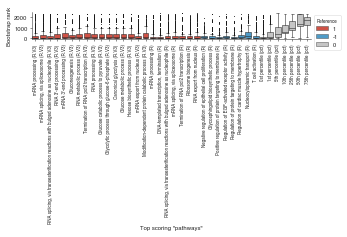

In [25]:
library = 'GO_Biological_Process_2018'
phenotype = 'innate_nonspecific_24h_wo_LAC_IL10_IL1ra'
region_filter = misc.GENE_AND_DISTAL_10kb
ranks_df = pd.read_csv(os.path.join(fig_dir, 'enr_{}_{}_{}_bootstrap.csv'.format(library, MODEL_TEMPLATE.format(phenotype), region_filter)), index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(5, 0.5))
ax = sns.boxplot(data=ranks_df, x='pathway_coef', y='rank', hue='hue',
                 flierprops=dict(markerfacecolor='k', marker='.', rasterized=RASTER,
                                 markersize=ERROR_FLIER_SIZE, markeredgewidth=0.0), dodge=False,
                 hue_order=[1, -1, 0],
                 palette=['#cf5246', '#4f9bc7', '#c5c5c5'], saturation=1)
plt.setp(ax.artists, edgecolor='k', lw=0.5)
plt.setp(ax.lines, color='k', lw=0.5)
ax.set_ylabel('Bootstrap rank')
ax.set_xlabel('Top scoring "pathways"')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticks([0, 1000, 2000])
ax.tick_params(axis='x', labelsize=SMALL_FONT)
ax.legend(bbox_to_anchor=(1, 1), title='Reference')
sns.despine()

if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, 'enr_{}_{}_{}_bootstrap_boxplots.svg'.format(library, MODEL_TEMPLATE.format(phenotype), region_filter)), dpi=DPI)
plt.show()

In [26]:
if SAVE_TABLES:
    infos, tables = misc.close_tables_and_save(suppl_tables)
    for table, df in zip(tables, infos):
        print(table)
        display(df)

In [ ]:
misc.fix_font_for_suppl_tables(suppl_tables)